In [1]:
import os
import sys

sys.path.append('..')

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from utilities import overlap_top_tr, get_hessian_eigenvalues

In [8]:
import seaborn as sns

In [3]:
evec_history = os.path.join("..", "..", "storage", "evec_history")

In [4]:
def plot_heatmap_overlap(data_dir, t = 0):
    if t != 0:
        suffix = f"-after-training-{t - 1}.pt"
    elif t == 0:
        suffix = "-before-training.pt"
    matrix = torch.zeros(size=(5, 5))
    for i in range(0, 5):
        for j in range(0, 5):
            first_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}" + suffix), weights_only=True)
            second_top_space = torch.load(os.path.join(data_dir, f"eivs-{j}" + suffix), weights_only=True)
            overlap = overlap_top_tr(first_top_space, second_top_space)
            matrix[i, j] = overlap
    
    plt.figure(figsize=(10, 8))
    _ = plt.imshow(matrix, cmap='viridis')
    plt.colorbar()
    plt.title(f'Top-space overlap after training on {t} experiences')
    plt.xlabel('Experience index')
    plt.ylabel('Experience index')
    
    # Add text annotations
    for i in range(5):
        for j in range(5):
            _ = plt.text(j, i, f'{matrix[i, j]:.2f}',
                         ha="center", va="center", color="w")
    
    plt.tight_layout()
    plt.show()


In [5]:
def plot_heatmaps_for_all_t(data_dir):
    def create_single_heatmap(ax, t):
        if t != 0:
            suffix = f"-after-training-{t - 1}.pt"
        else:
            suffix = "-before-training.pt"
        
        matrix = torch.zeros(size=(5, 5))
        overlap_sum = 0
        overlap_num = 0
        for i in range(5):
            for j in range(5):
                first_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}" + suffix), weights_only=True)
                second_top_space = torch.load(os.path.join(data_dir, f"eivs-{j}" + suffix), weights_only=True)
                overlap = overlap_top_tr(first_top_space, second_top_space)
                matrix[i, j] = overlap
                if i < j:
                    overlap_sum += overlap
                    overlap_num += 1
        
        im = ax.imshow(matrix, cmap='viridis')
        ax.set_title(f'After {t} experiences')
        ax.set_xlabel('Experience index')
        ax.set_ylabel('Experience index')
        
        # Add text annotations
        for i in range(5):
            for j in range(5):
                ax.text(j, i, f'{matrix[i, j]:.2f}',
                        ha="center", va="center", color="w", fontsize=8)
        
        return im, overlap_sum / overlap_num

    # Calculate number of rows needed
    num_plots = 6  # t from 0 to 5
    num_cols = 2
    num_rows = 3

    # Create the main figure and grid of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    fig.suptitle('Top-space overlap across training', fontsize=16)

    # Flatten axs array for easier indexing
    axs = axs.flatten()

    # Create heatmaps

    mean_overlaps = []
    for t in range(6):
        im, mean_overlap = create_single_heatmap(axs[t], t)
        mean_overlaps.append(mean_overlap)
        fig.colorbar(im, label='Overlap')
        im.set_clim(0.0, 0.2)
    
    # Remove any unused subplots
    for i in range(num_plots, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    bars = plt.bar(["No training"] + [f"Trained on {i} exp." for i in range(1, 6)], mean_overlaps)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylabel('Mean overlap of different exp top-spaces')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    return mean_overlaps
    #  ax.set_title('Mean Overlap between the top subspaces calculated relative to different experiences.')


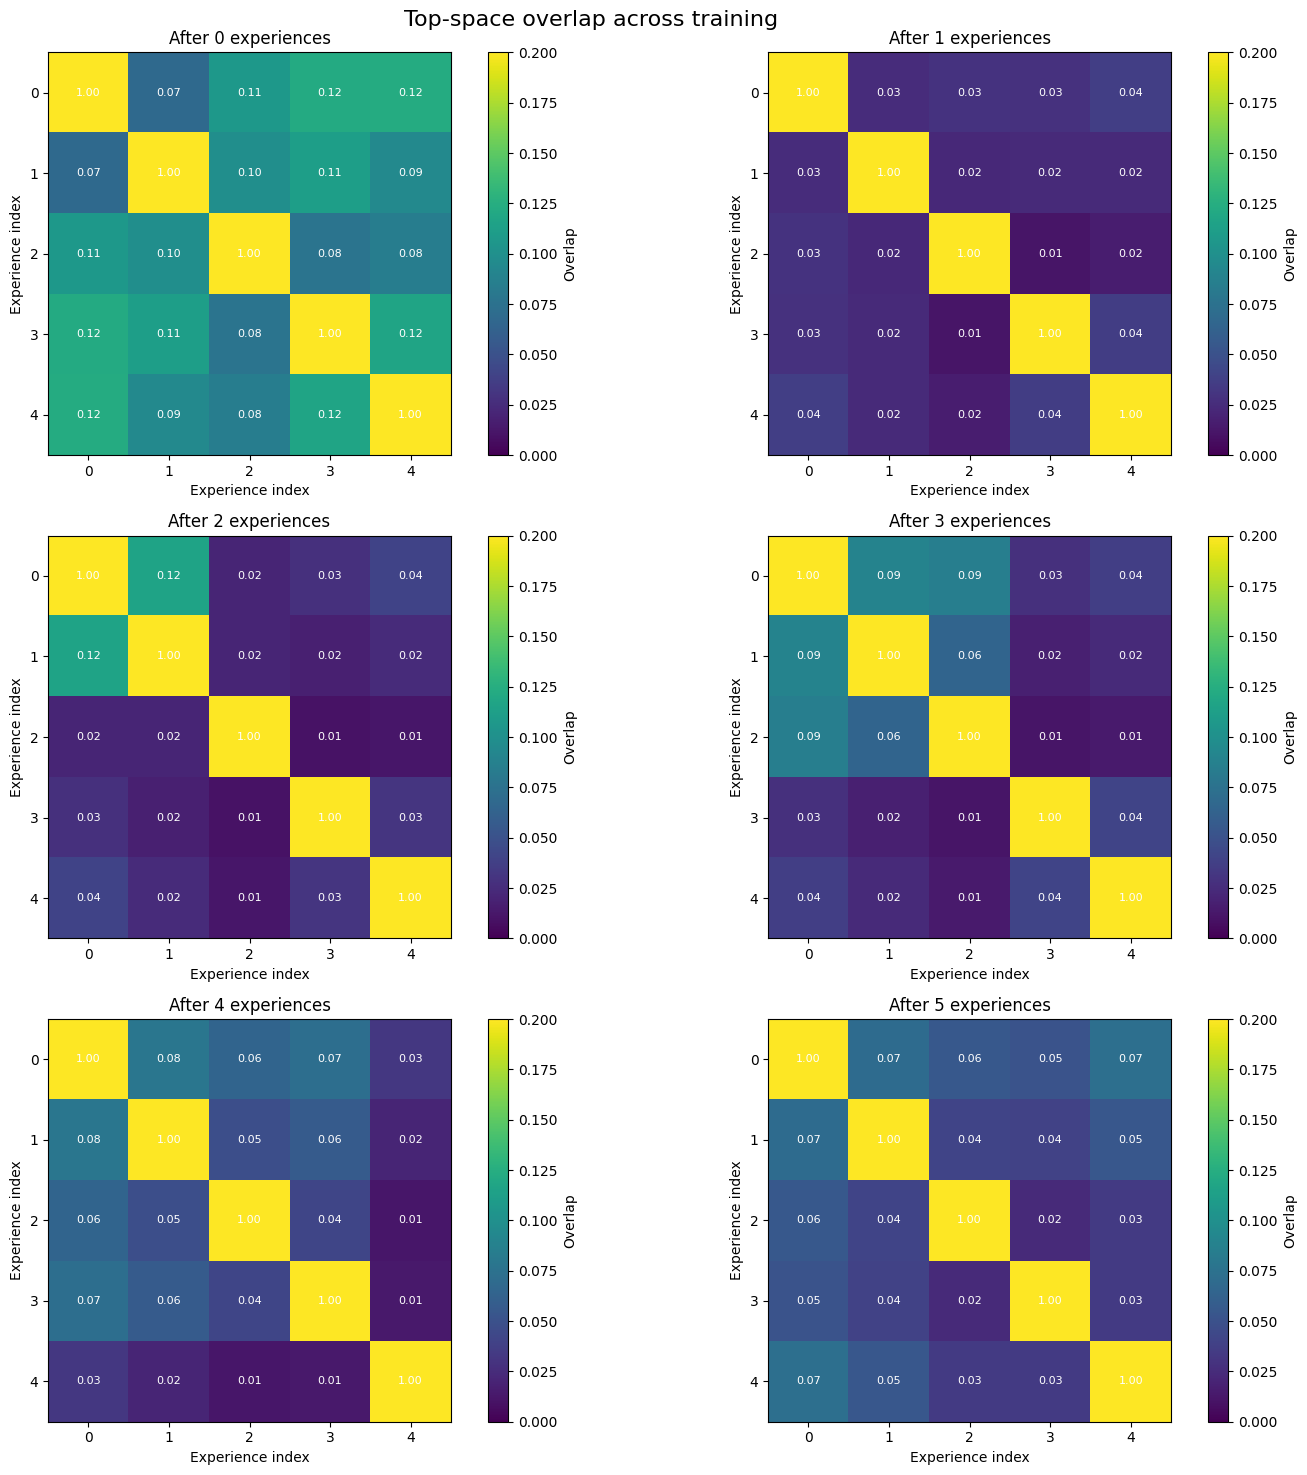

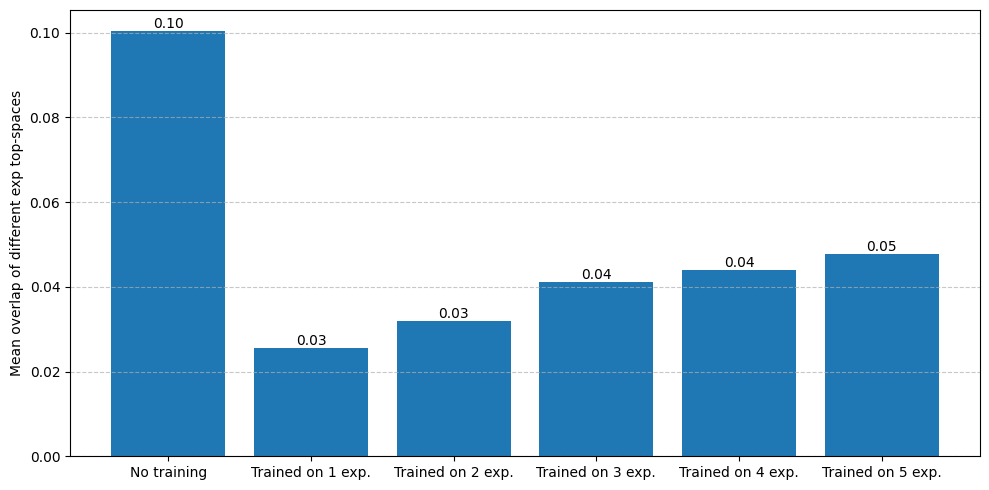

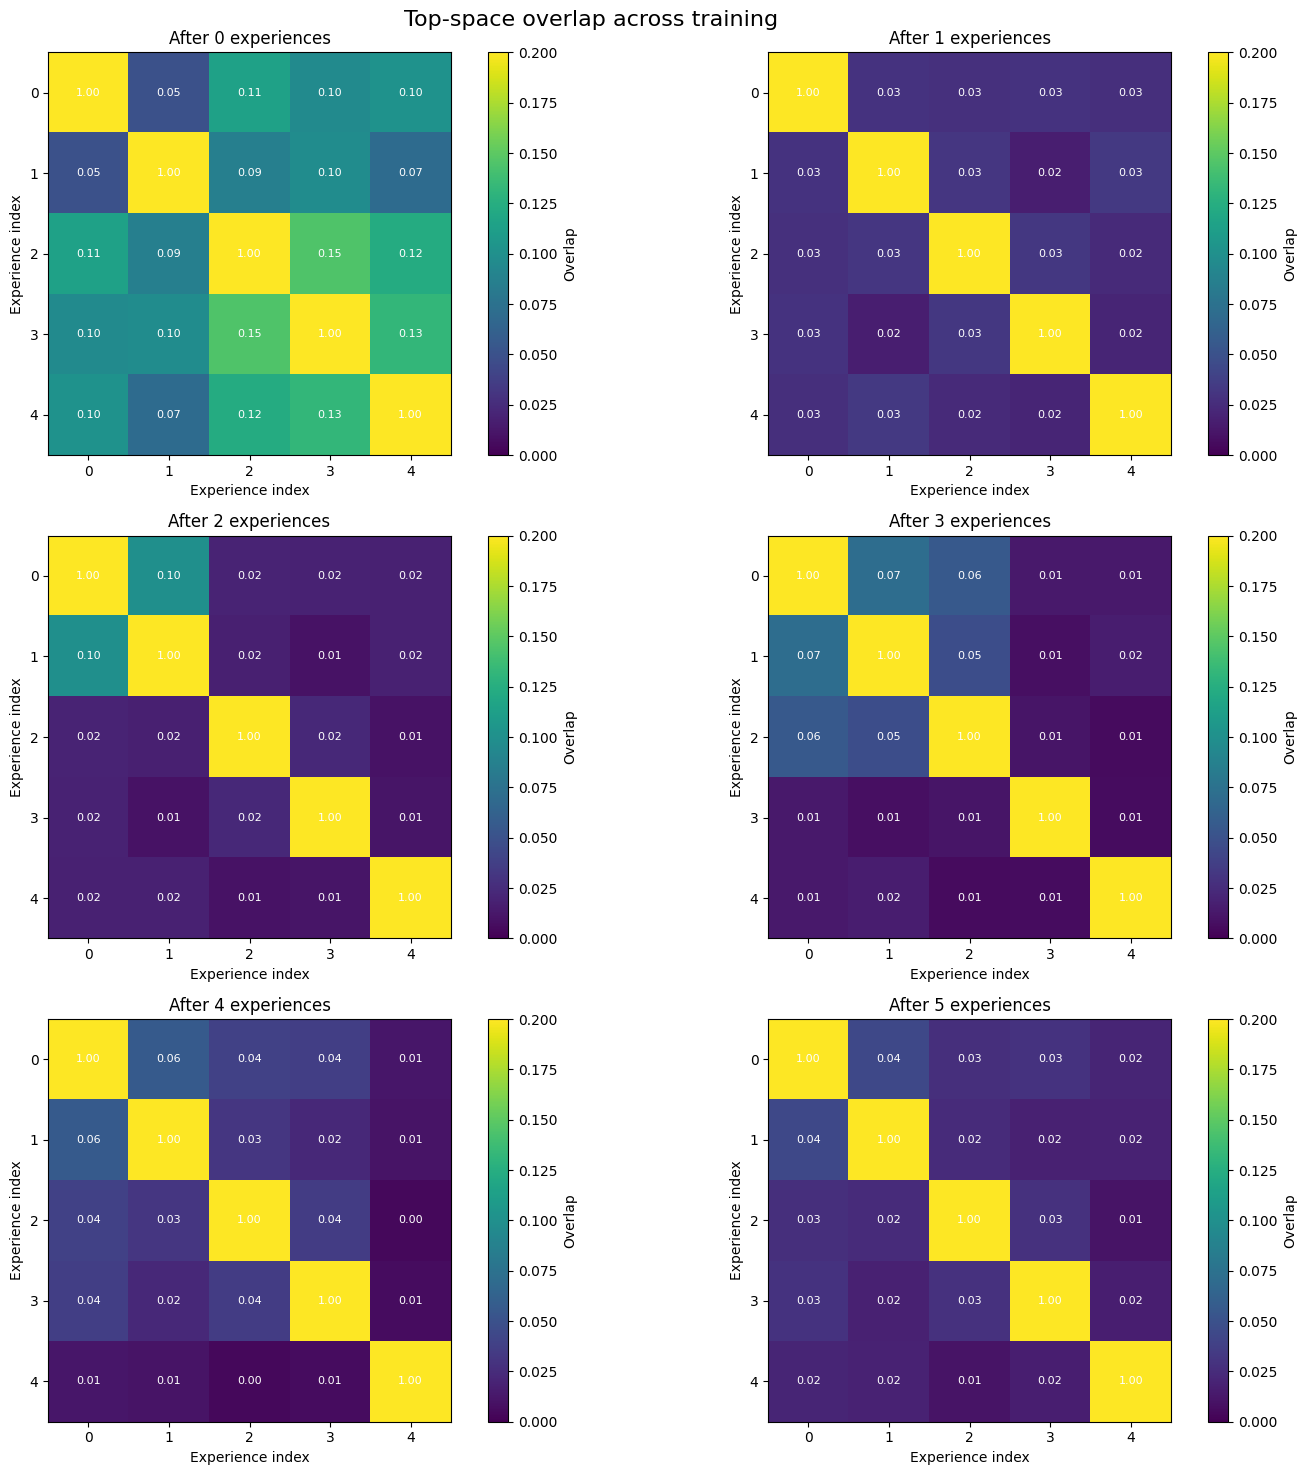

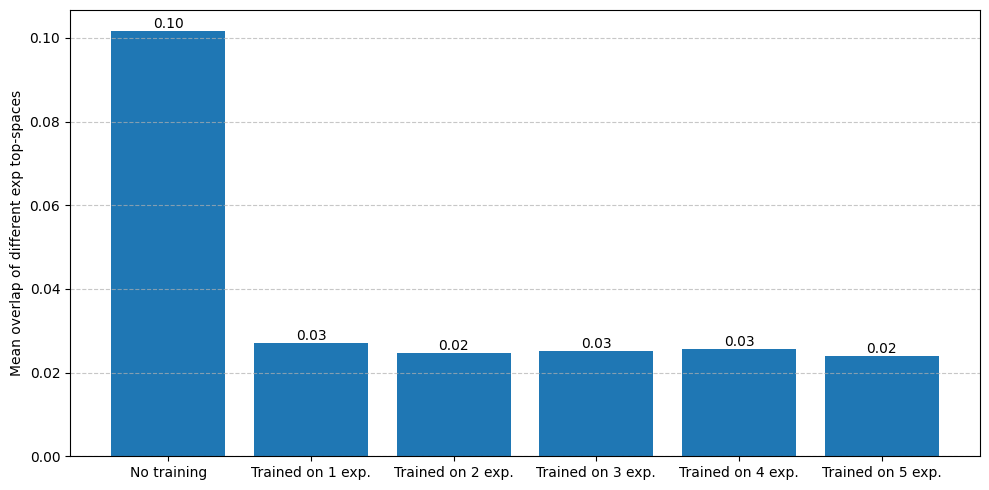

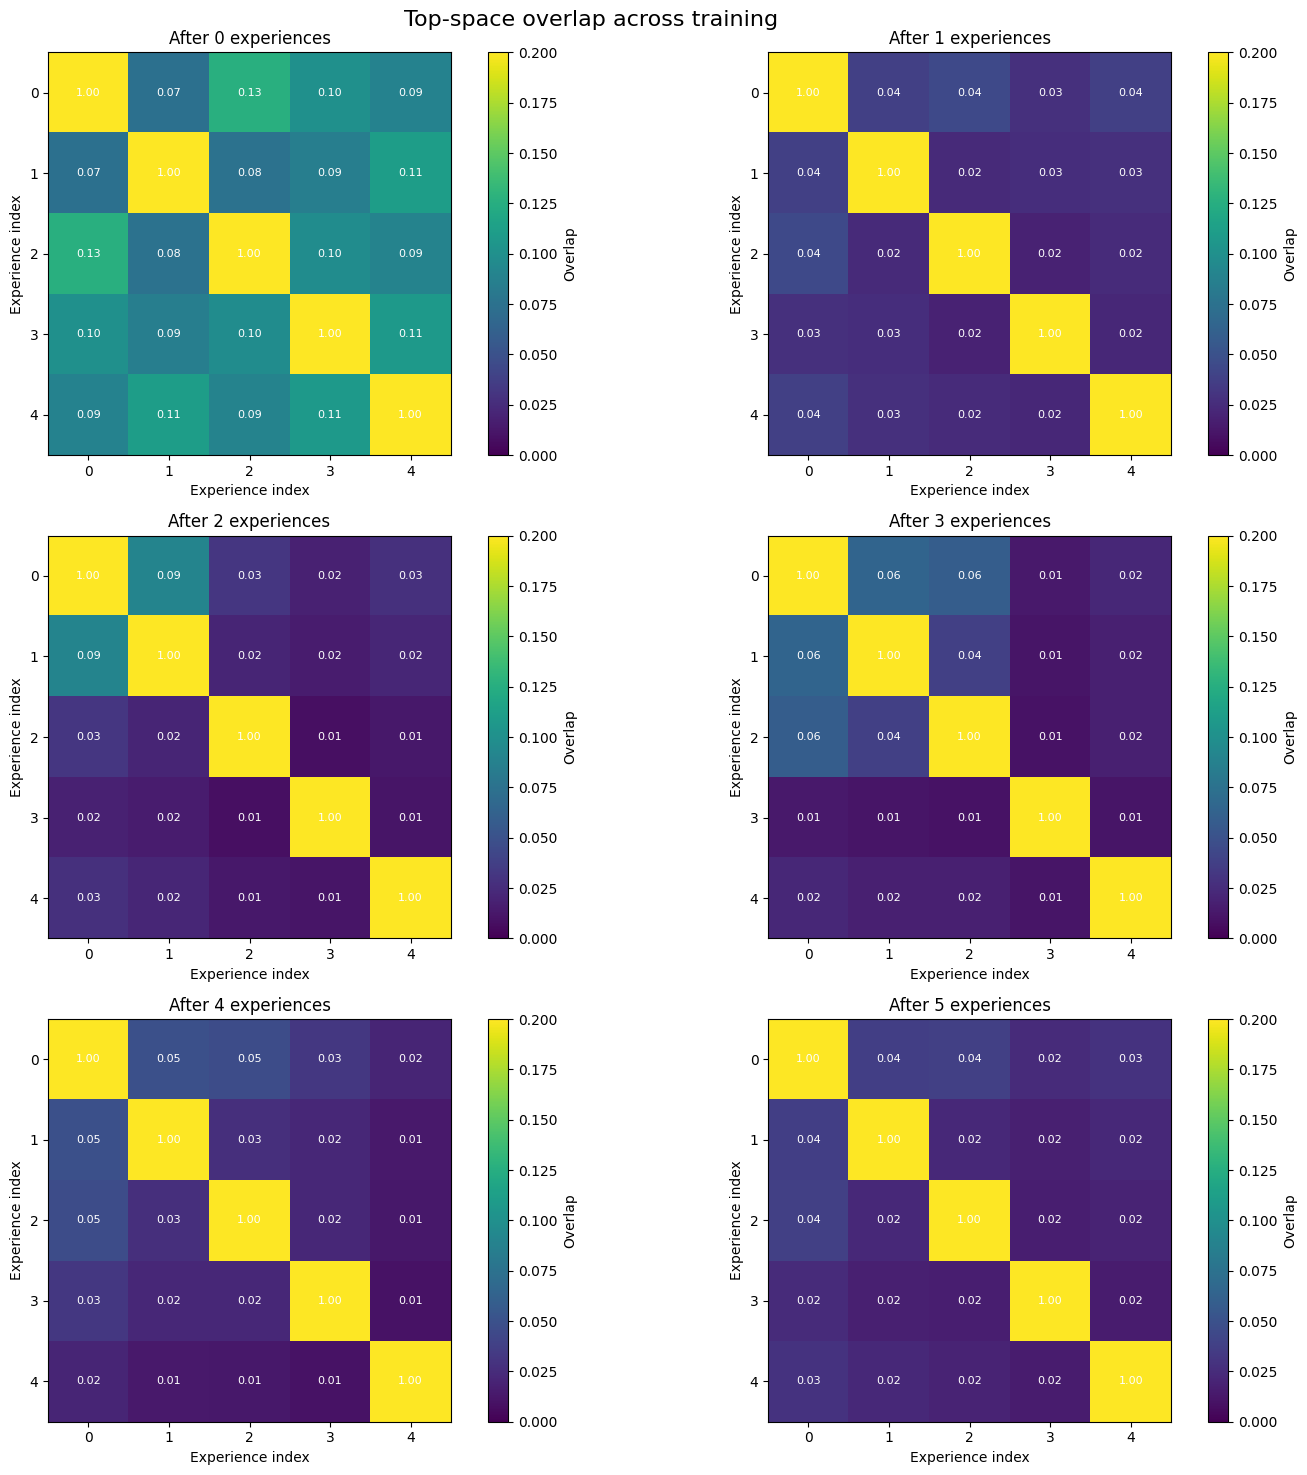

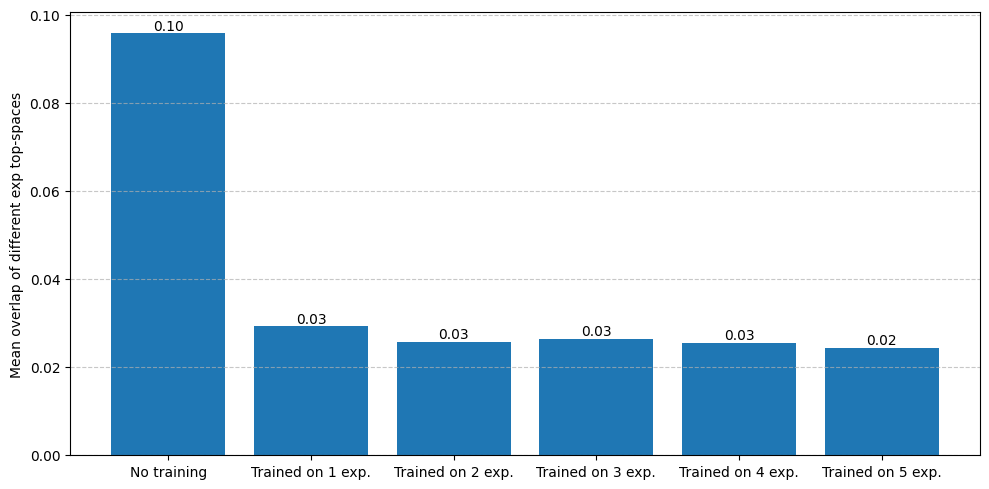

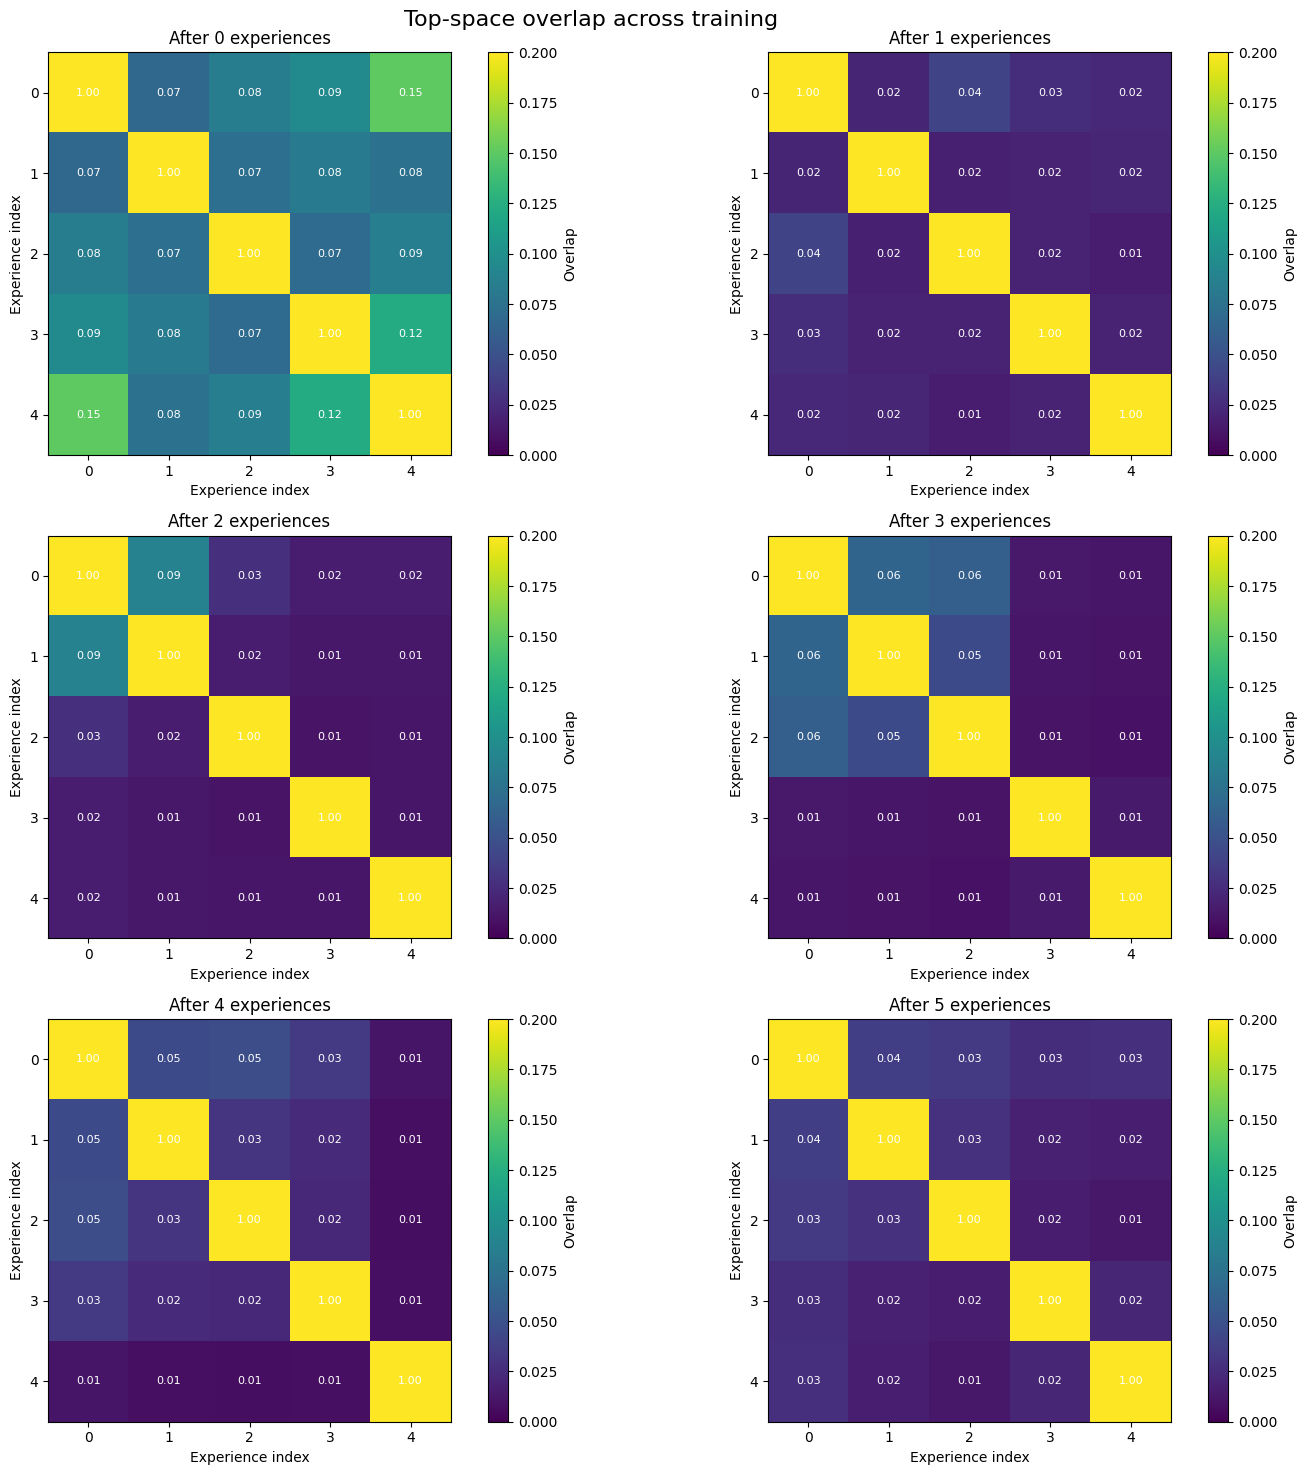

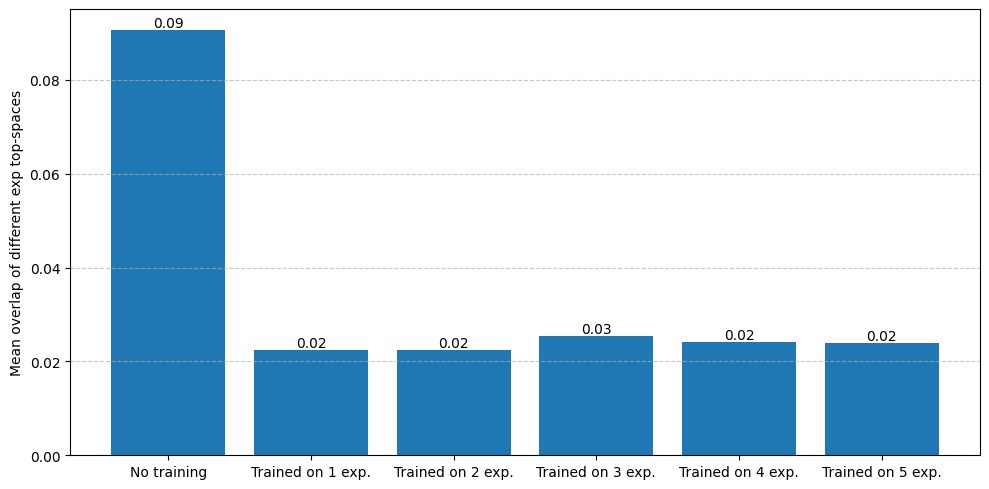

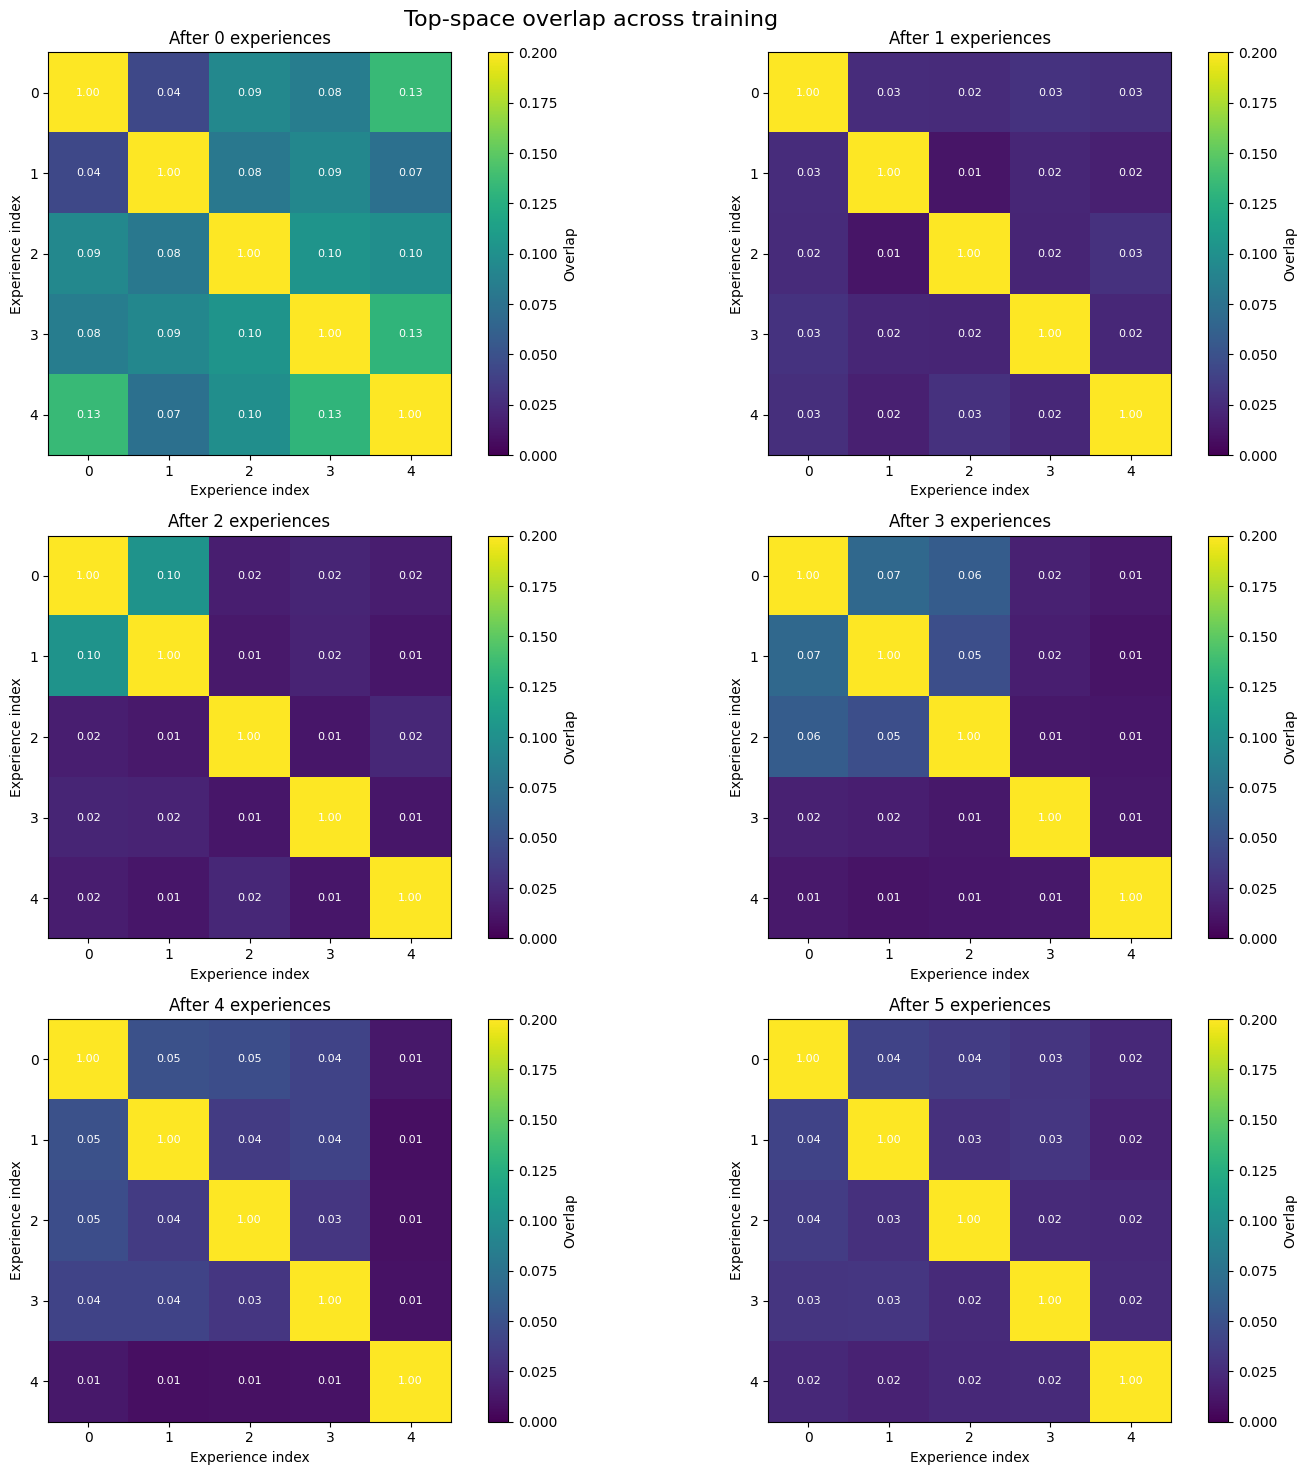

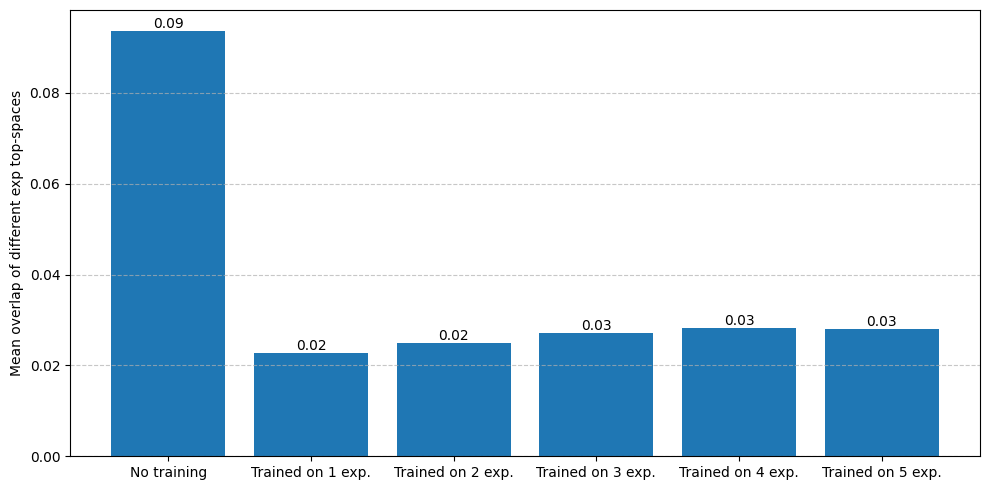

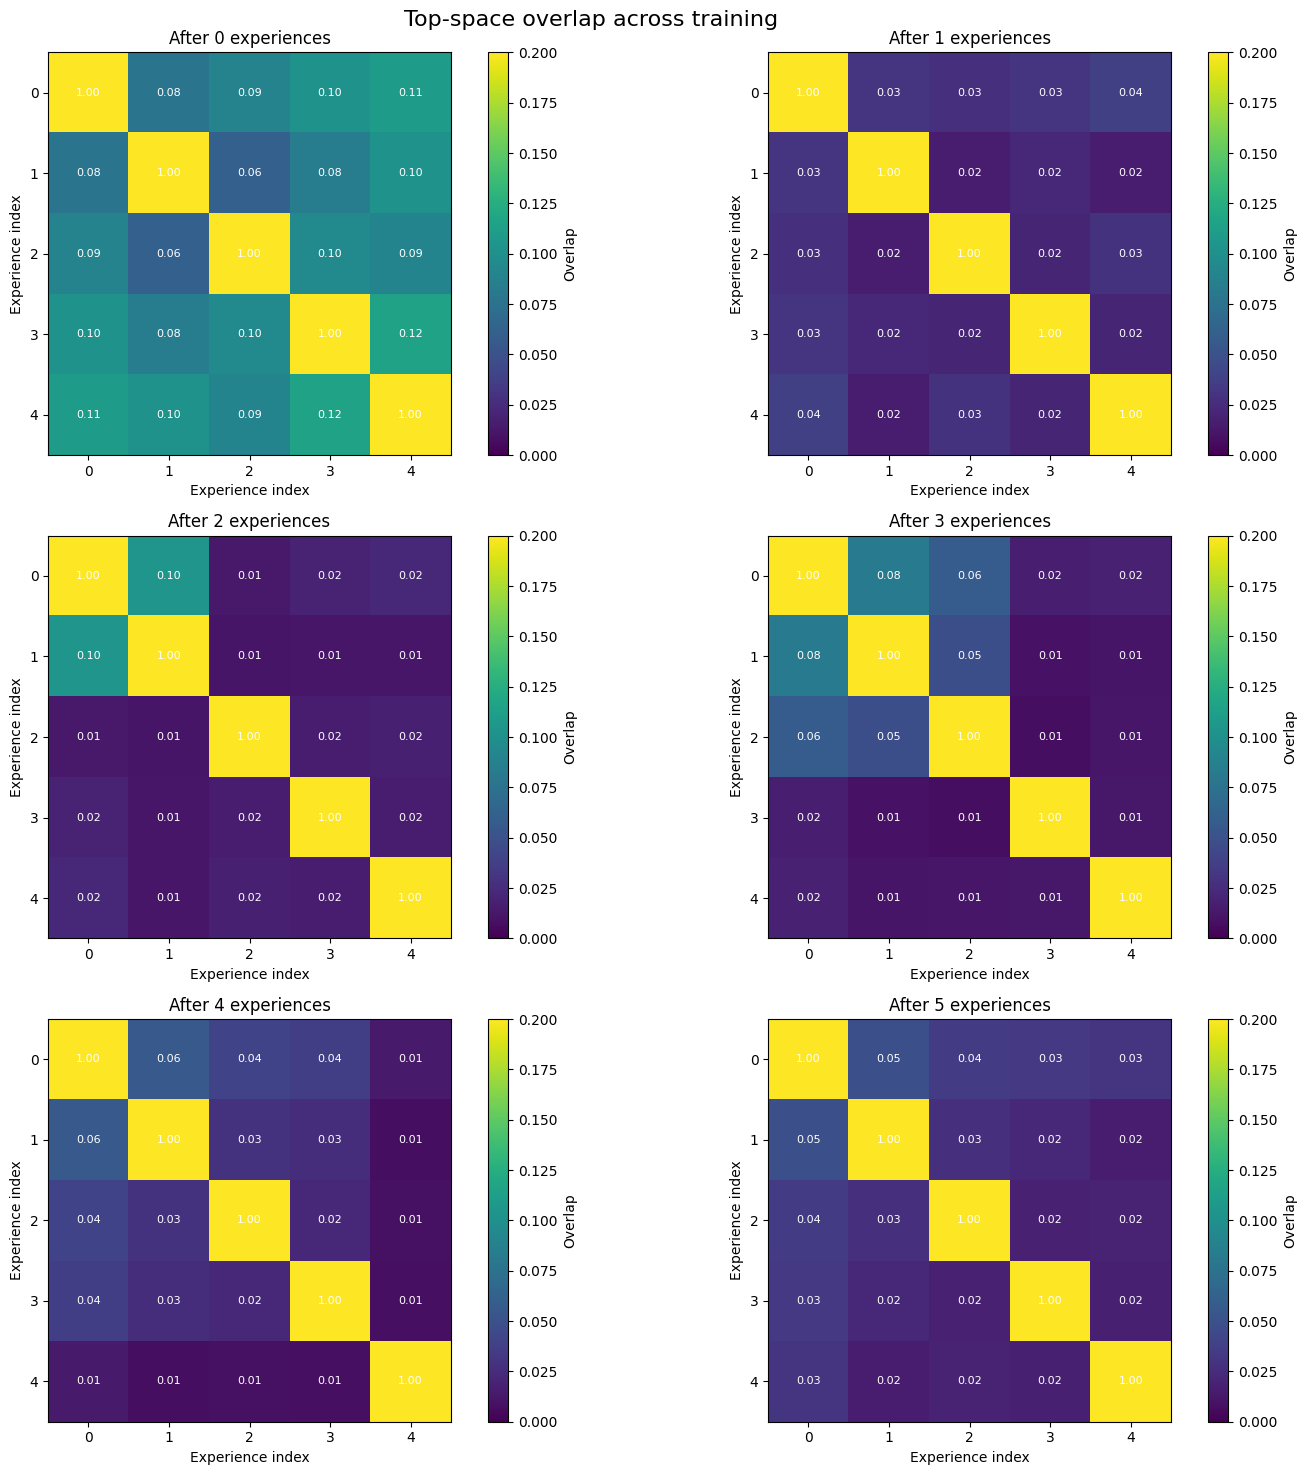

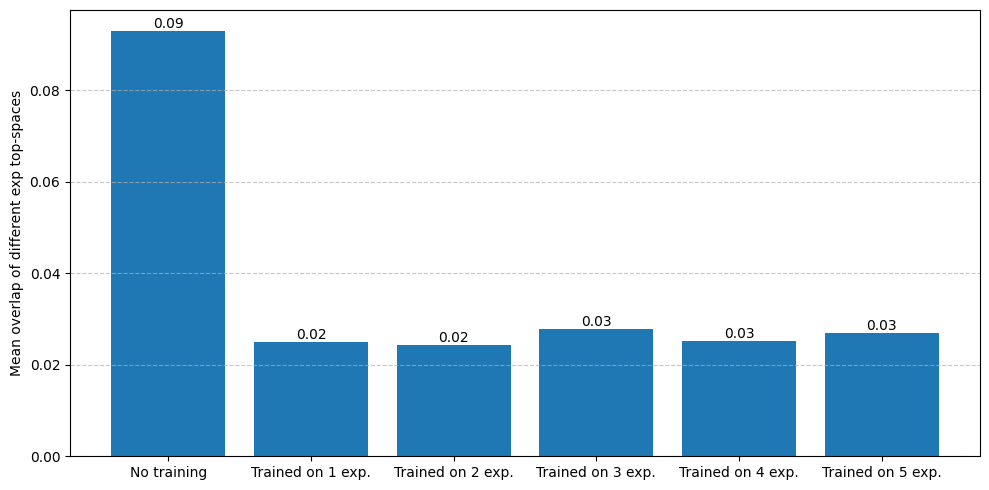

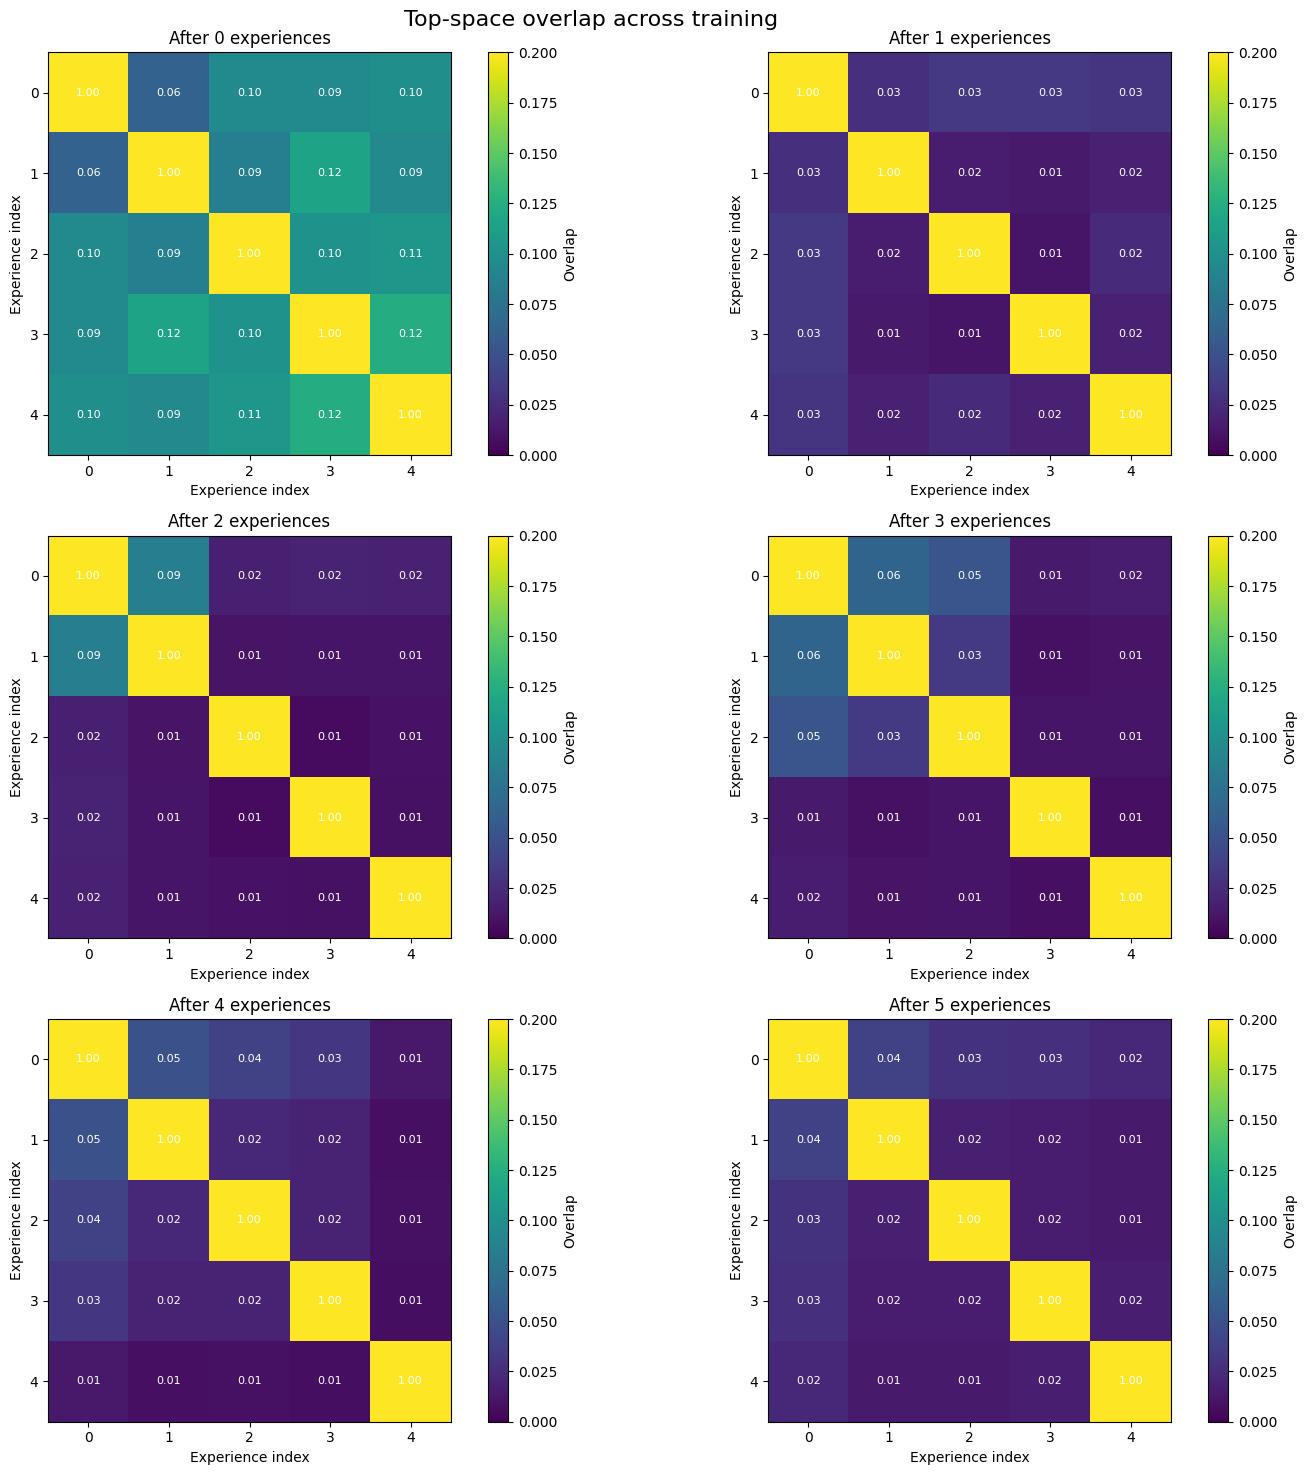

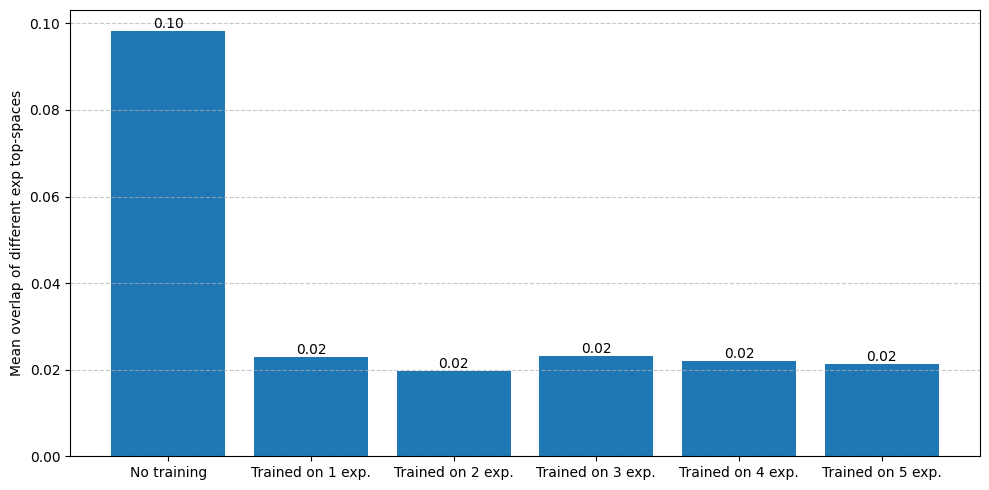

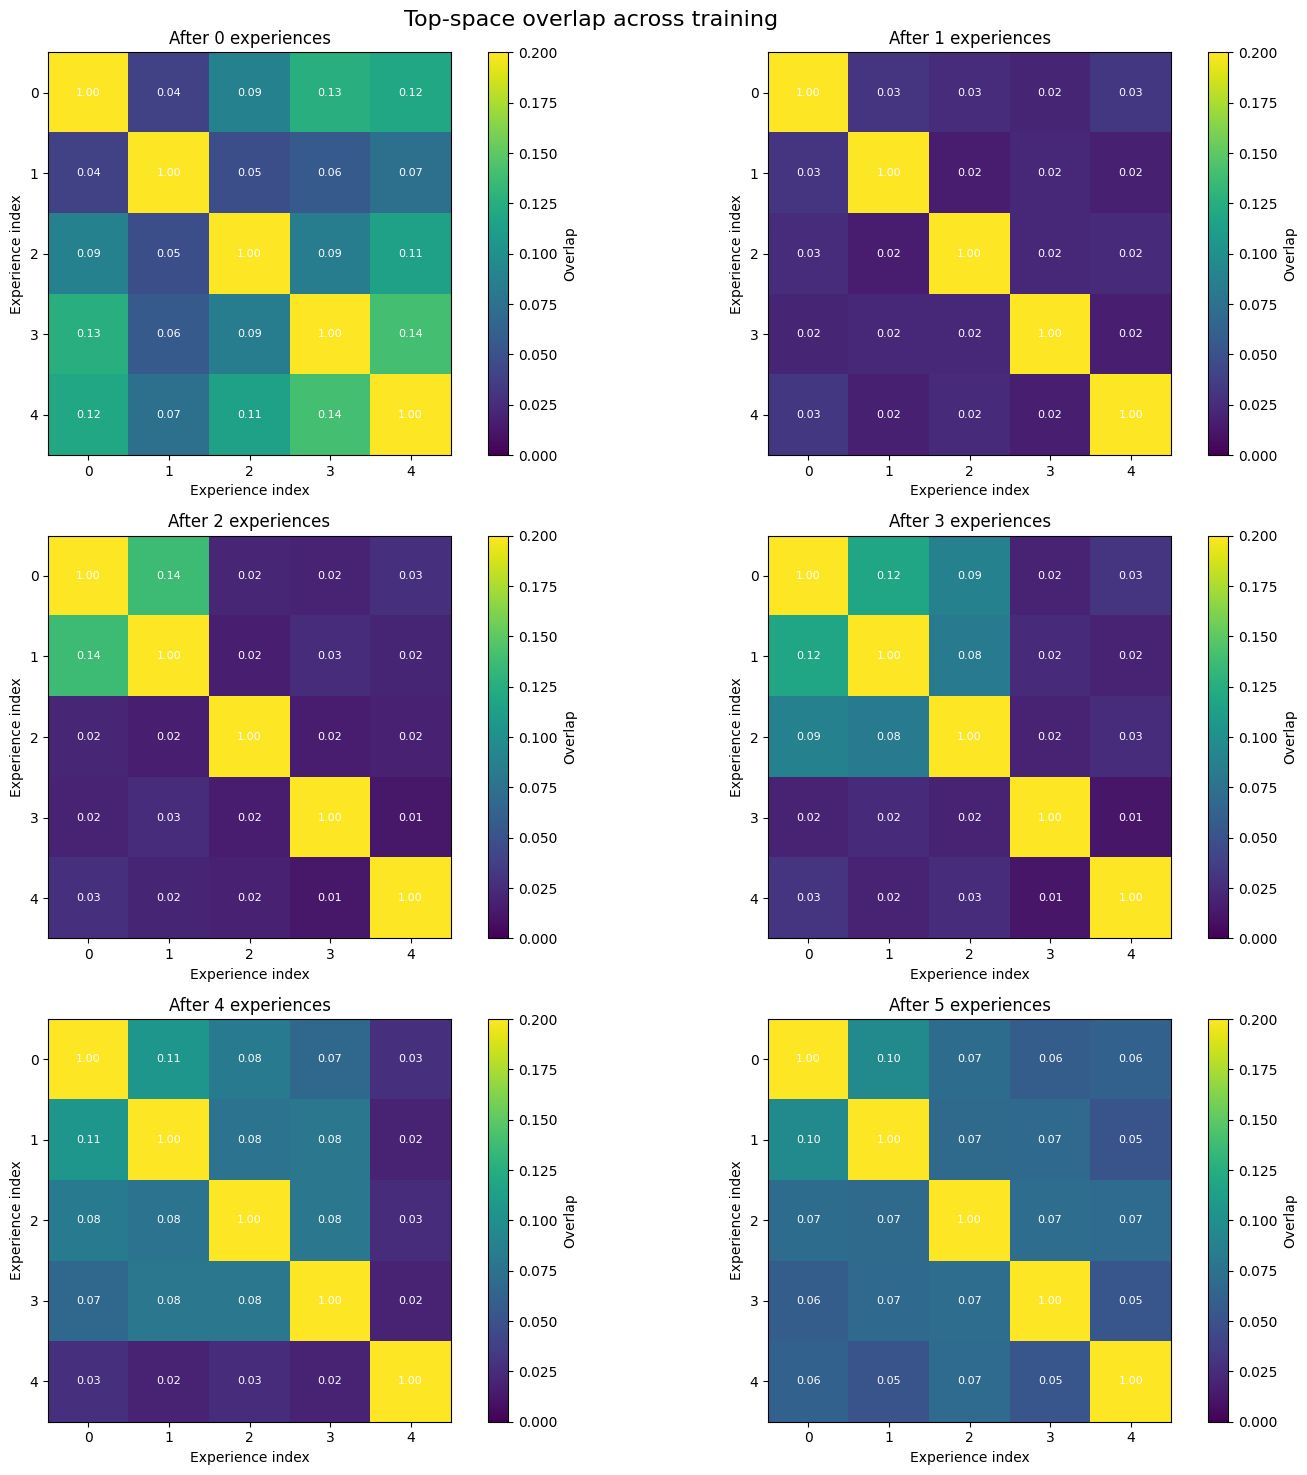

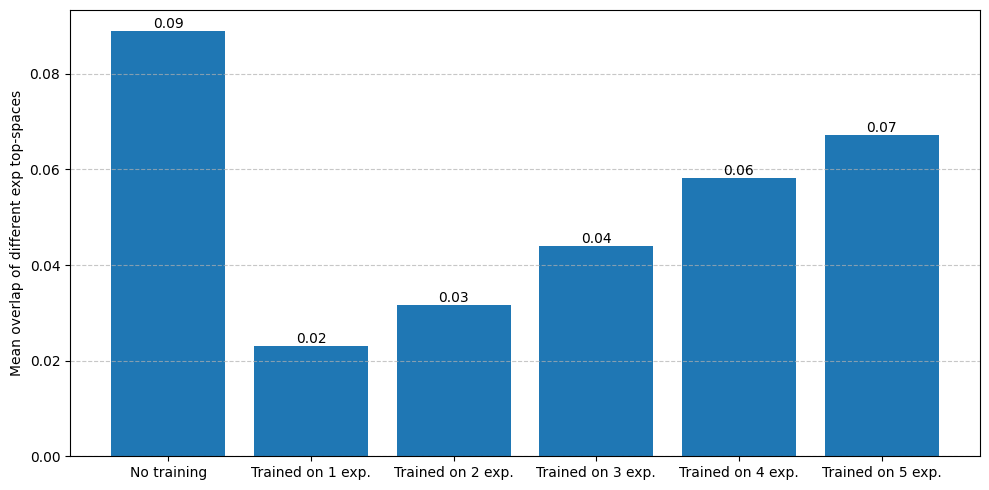

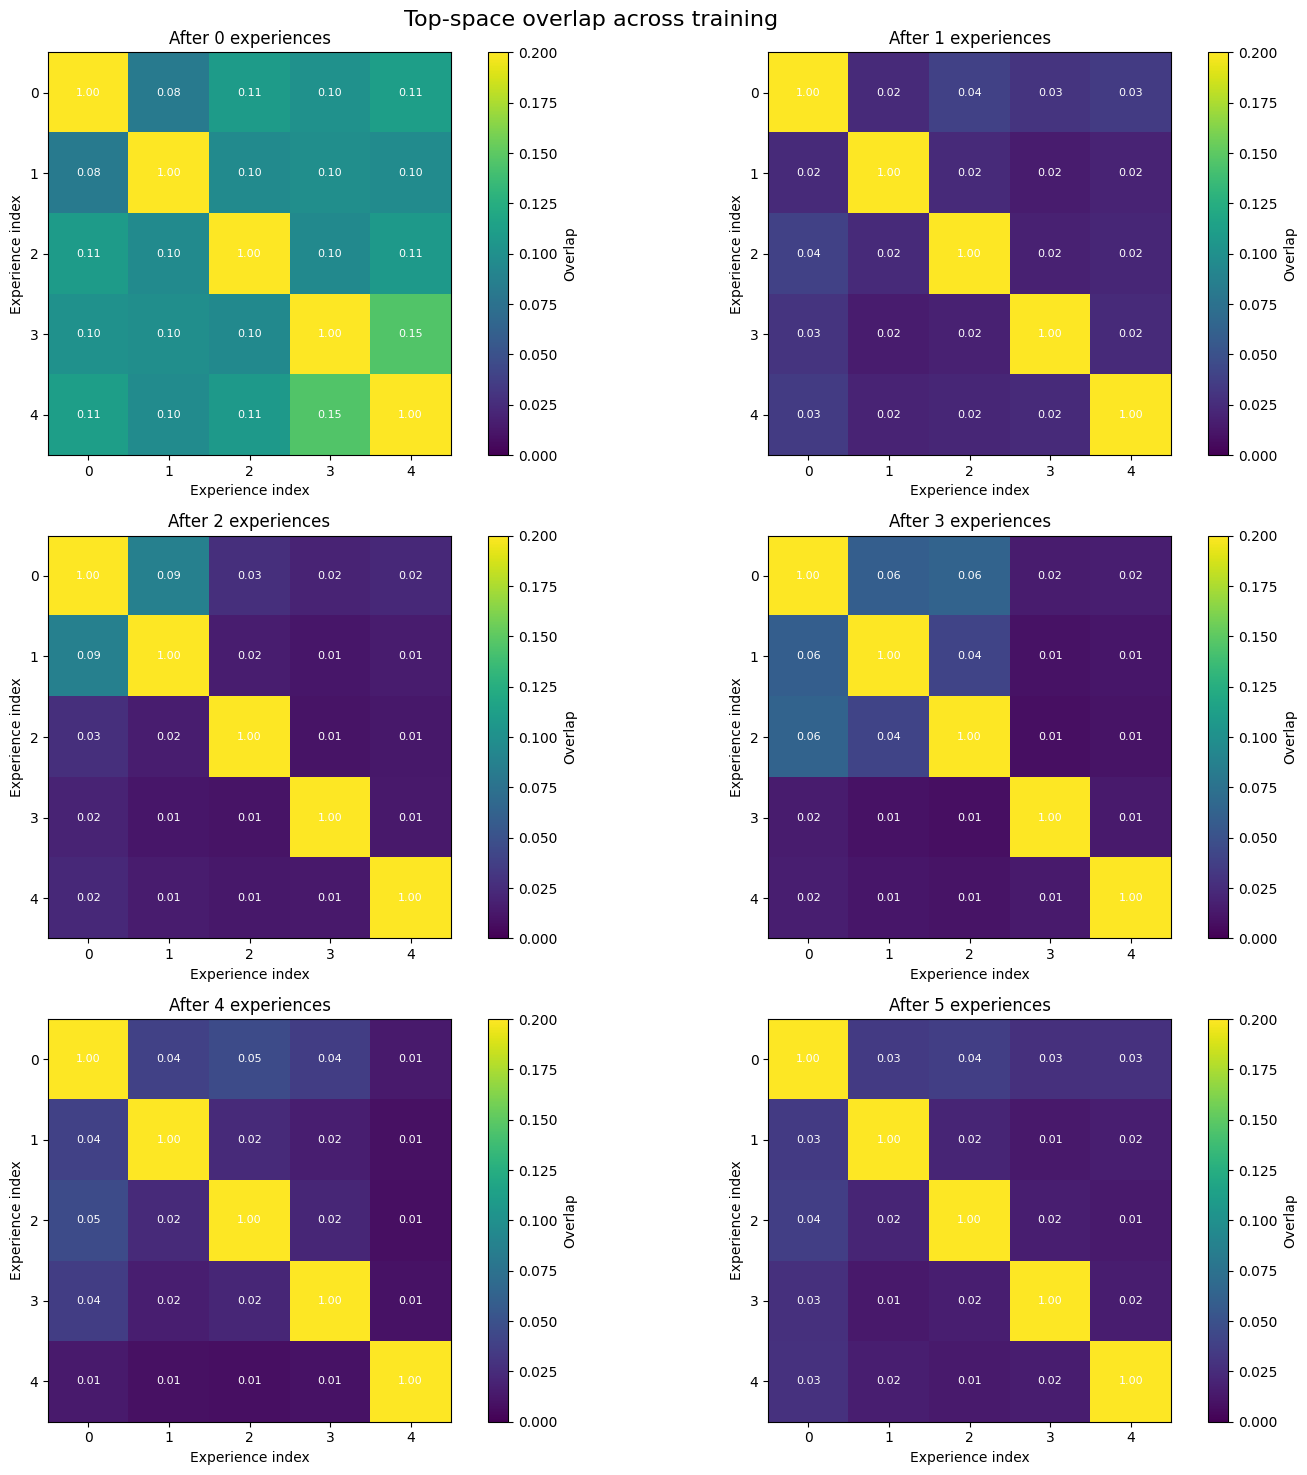

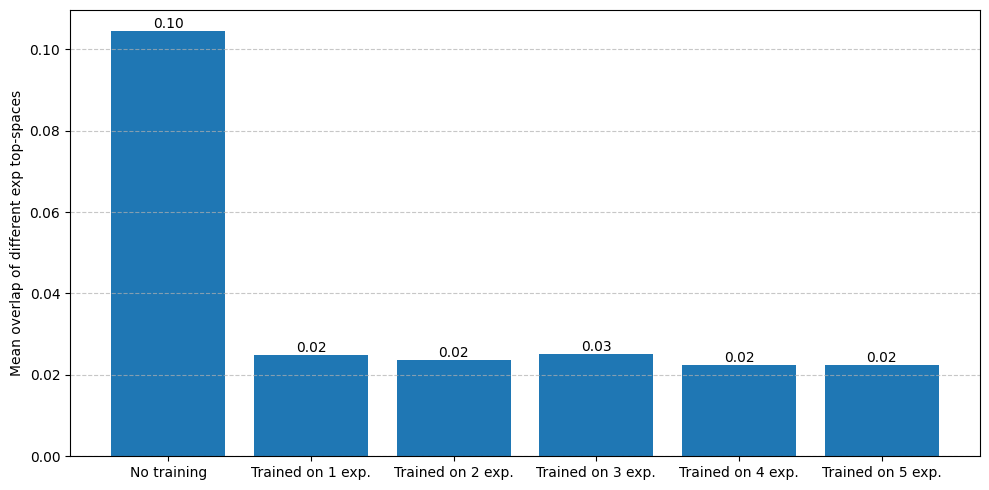

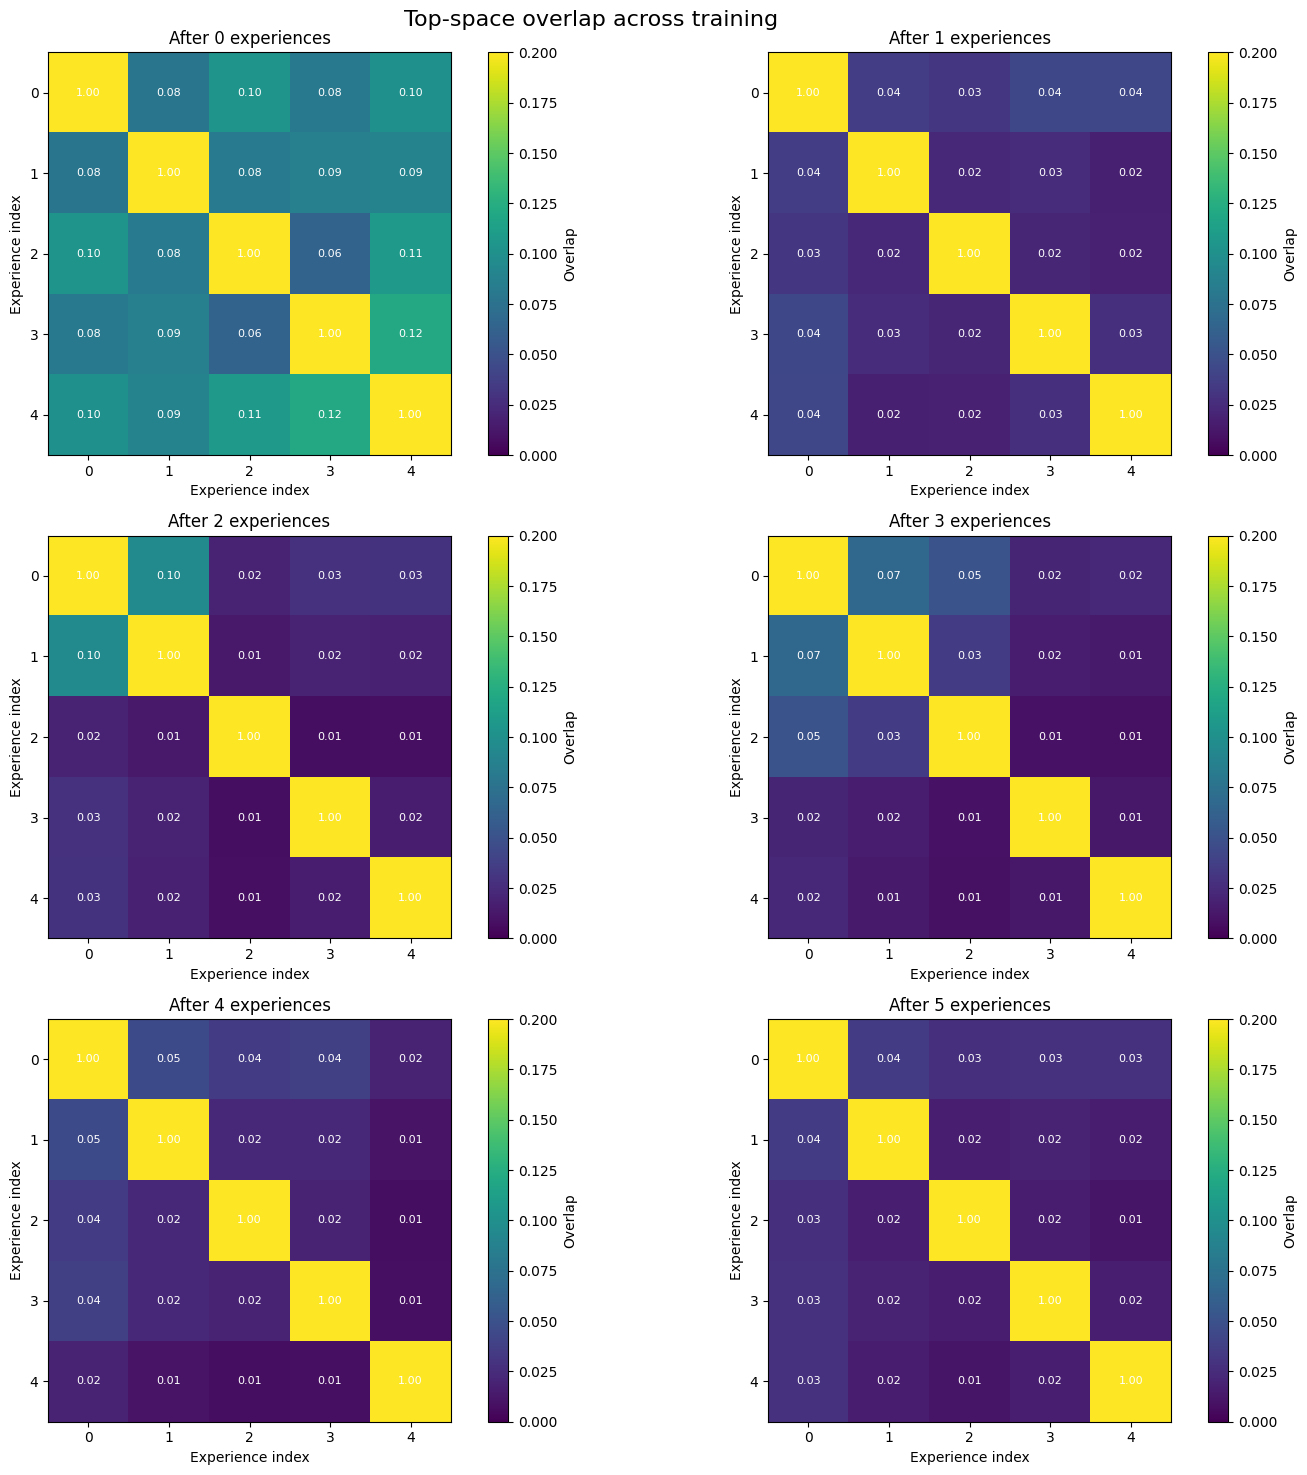

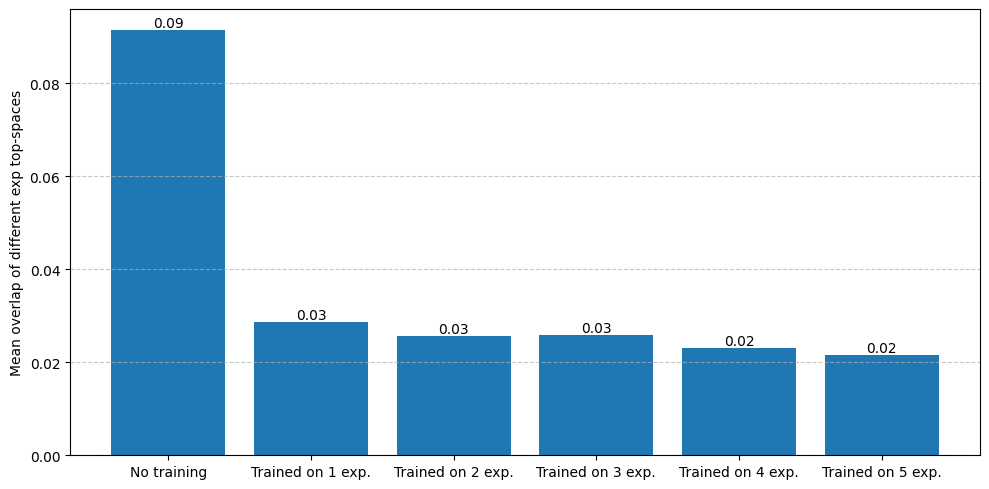

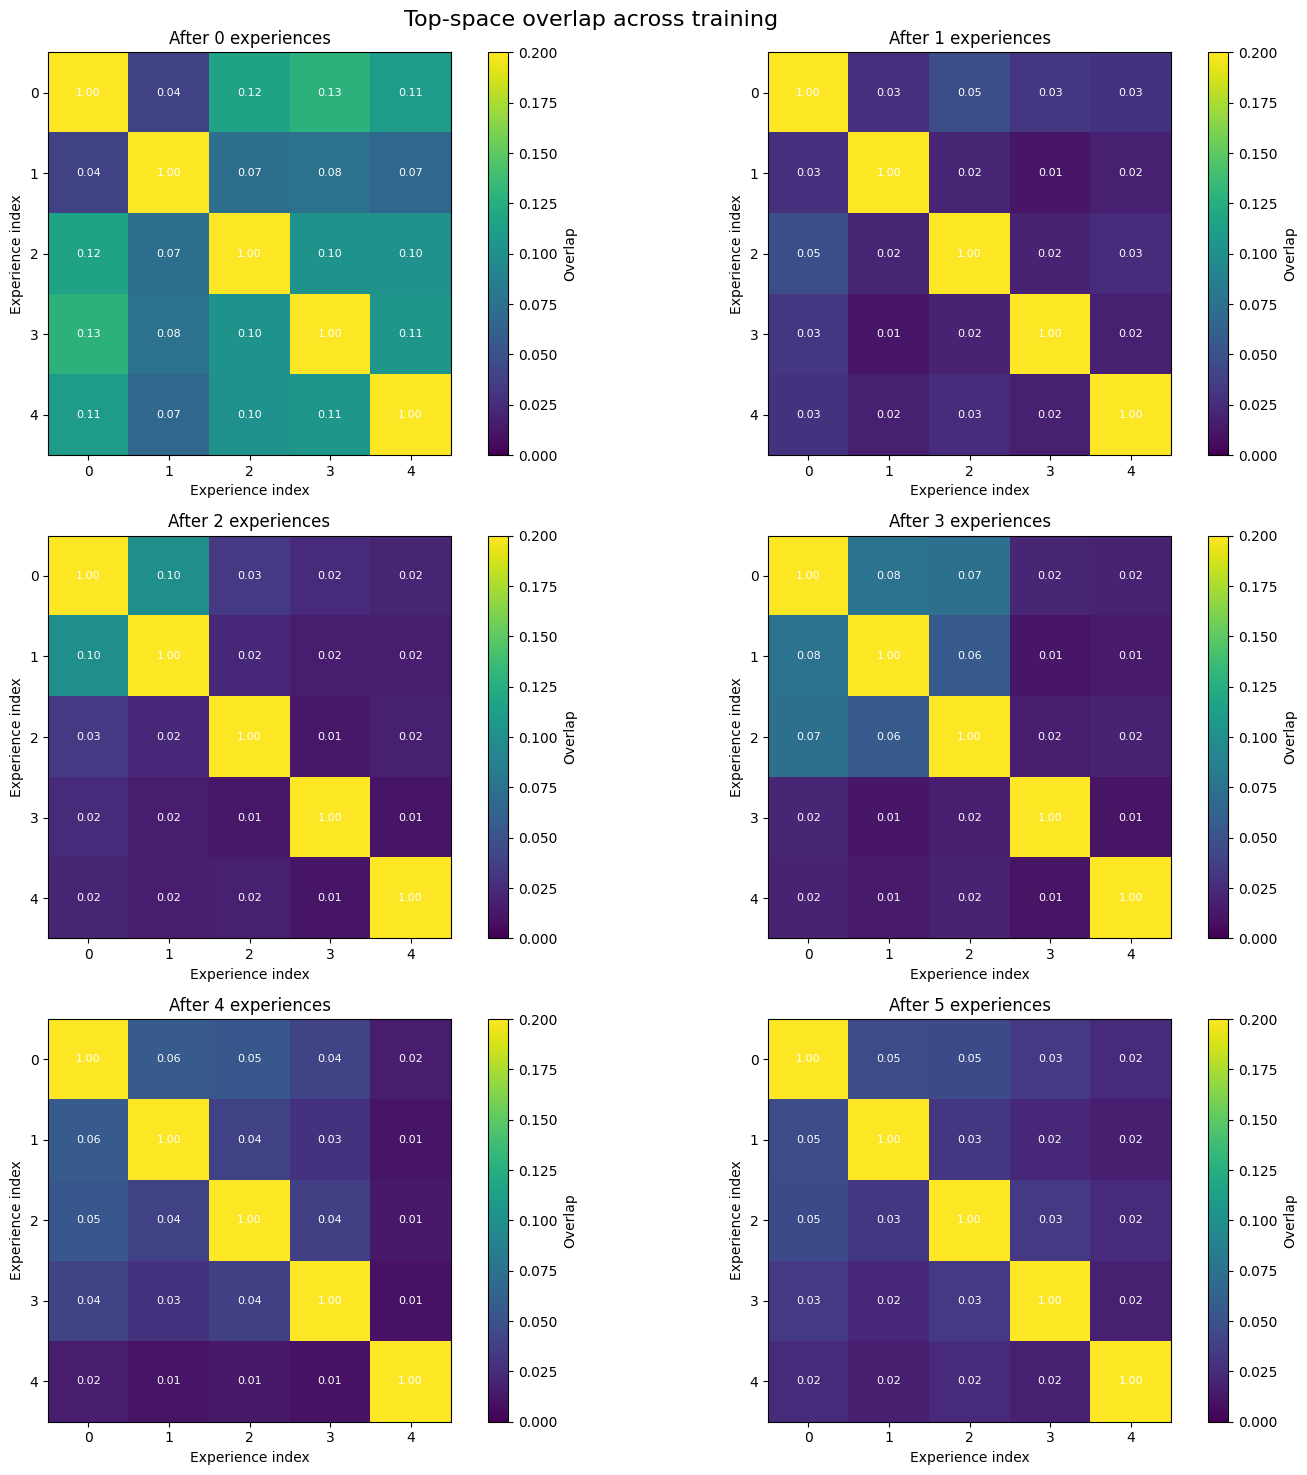

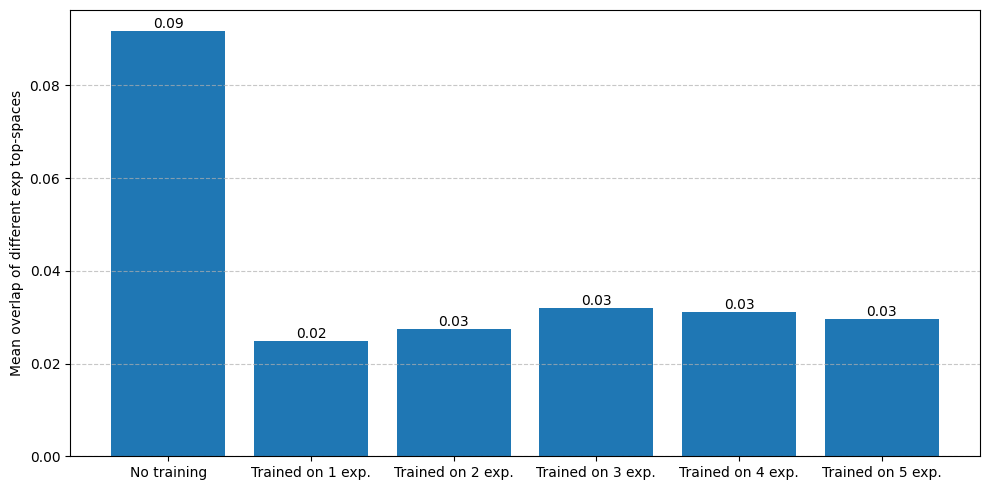

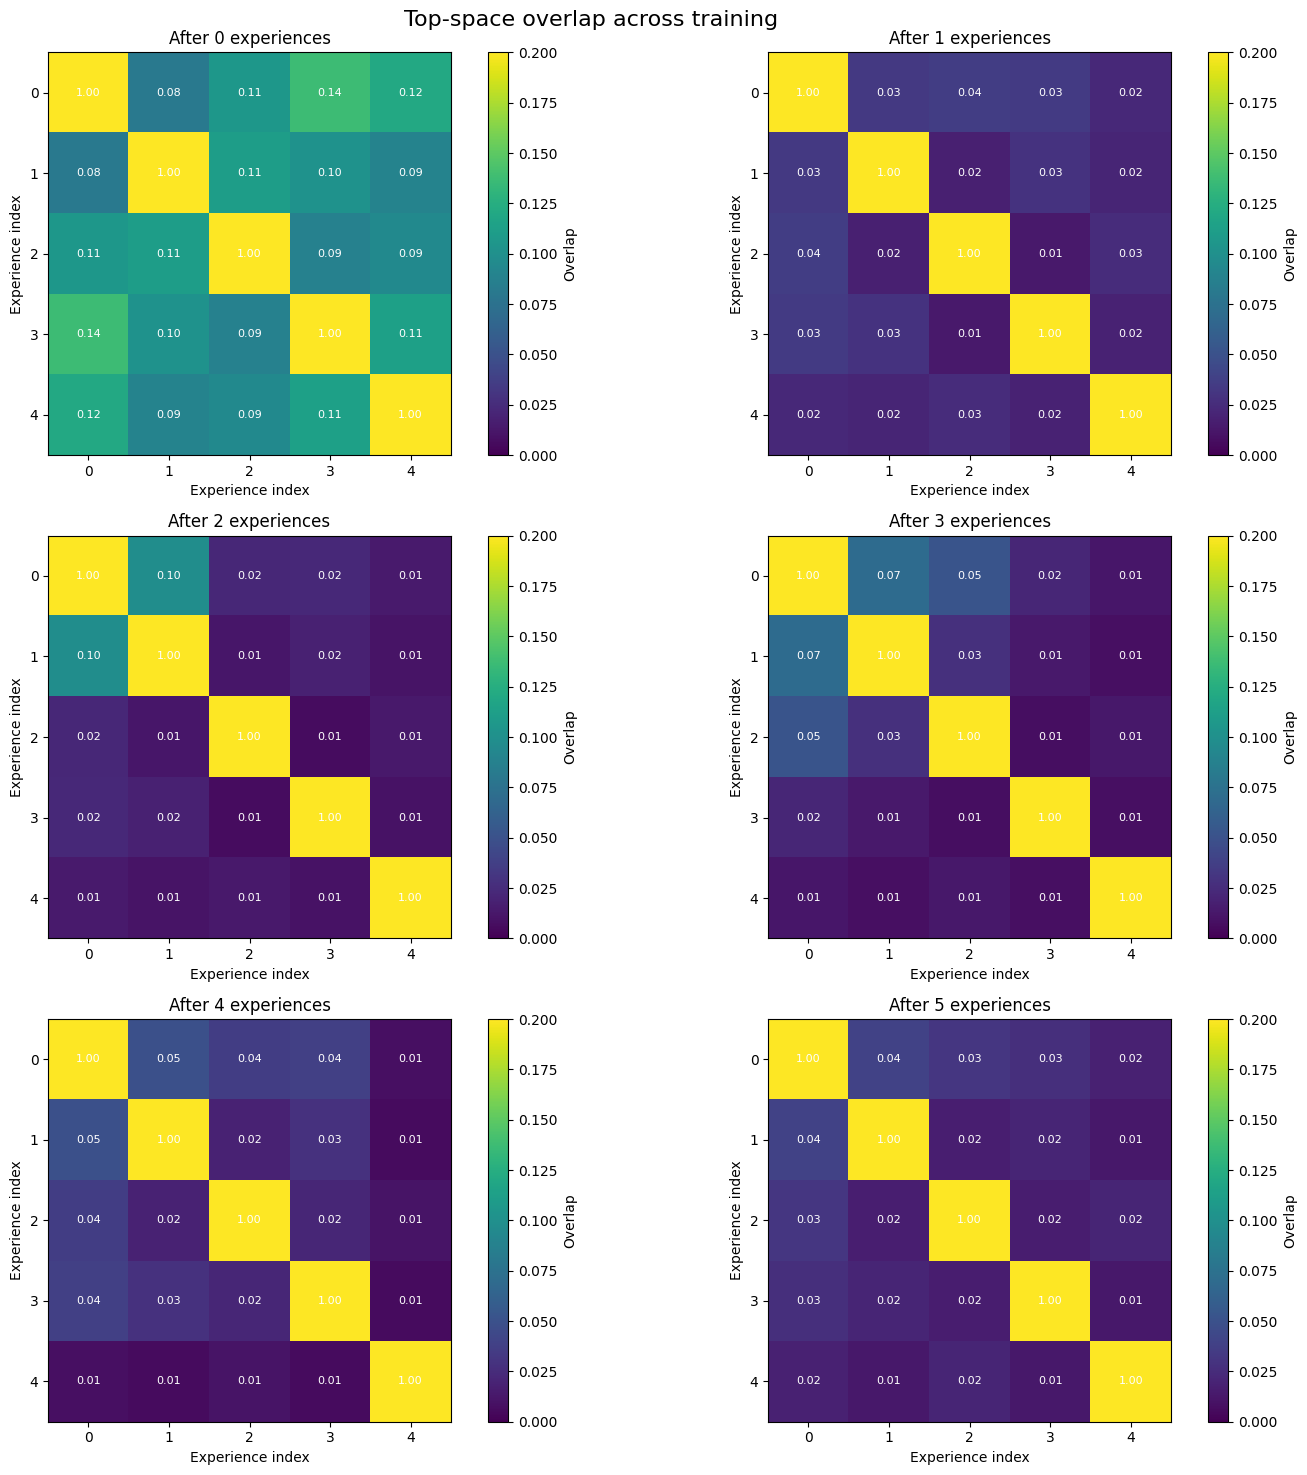

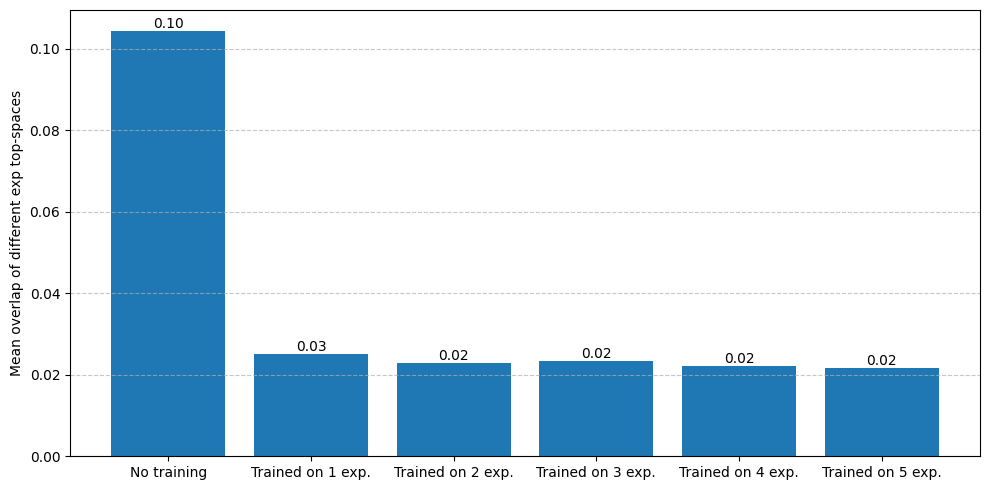

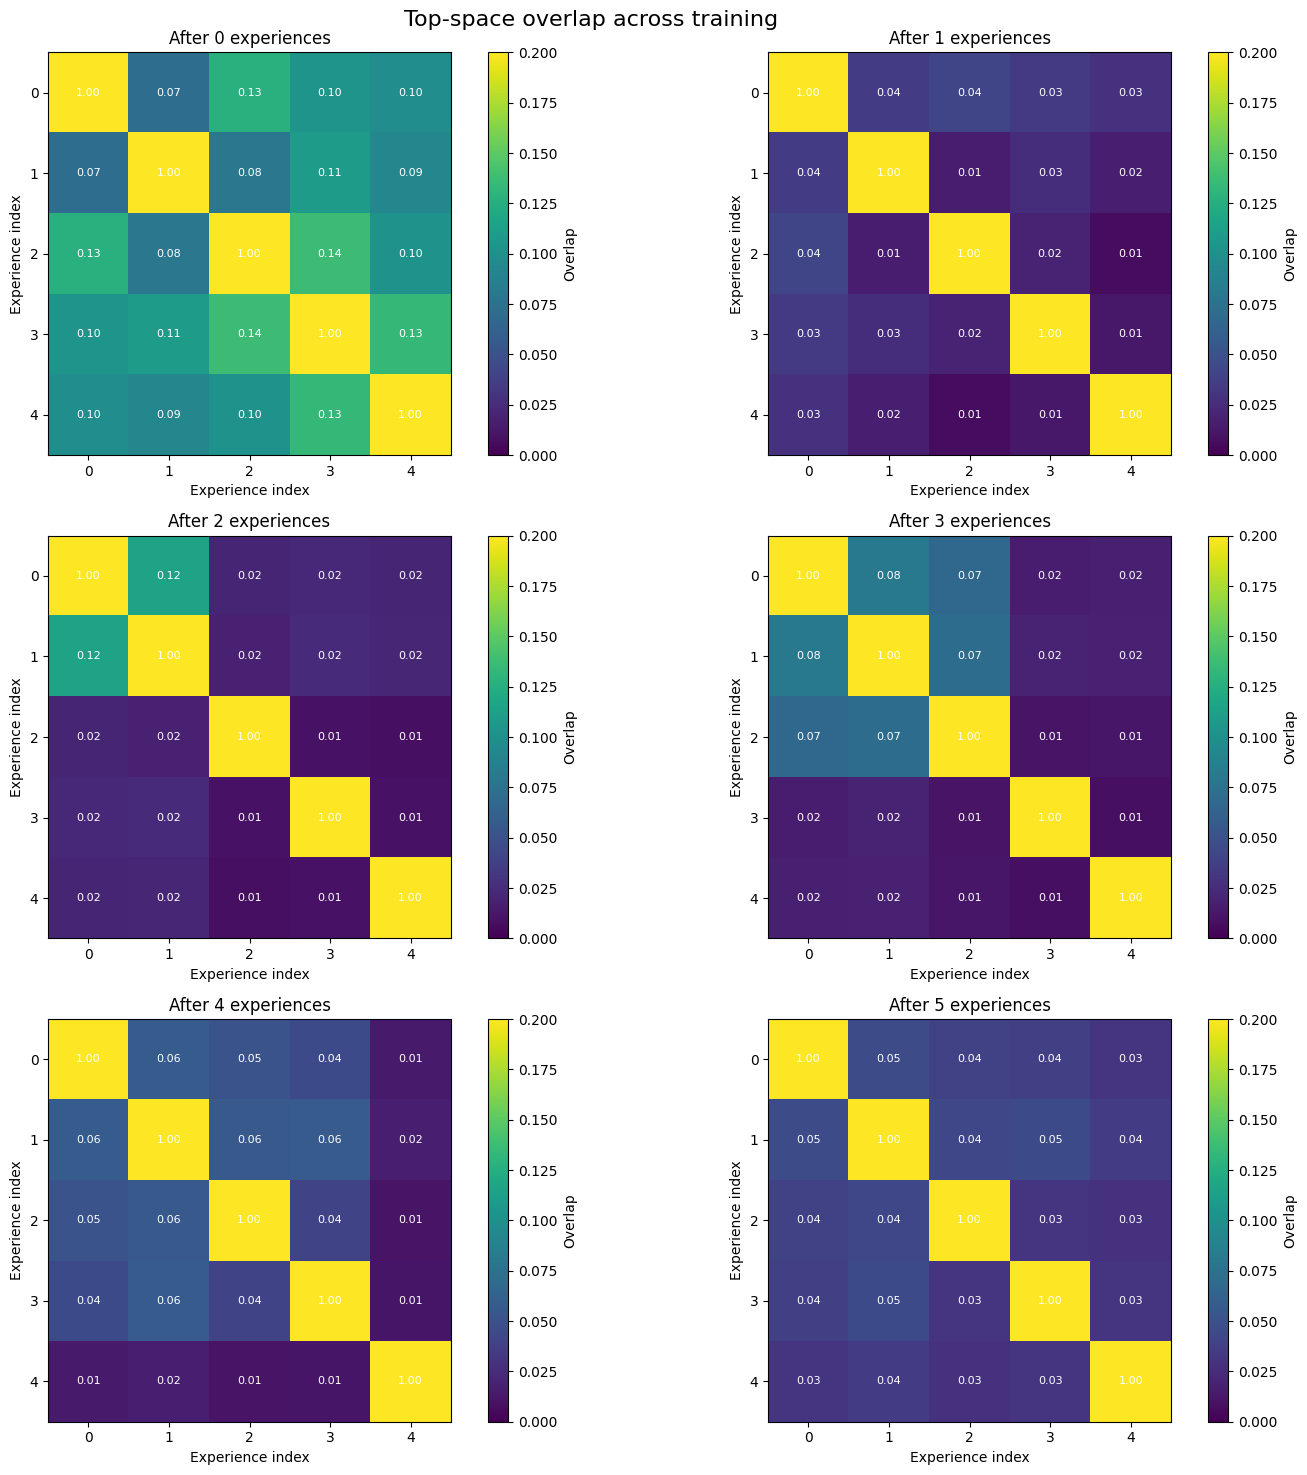

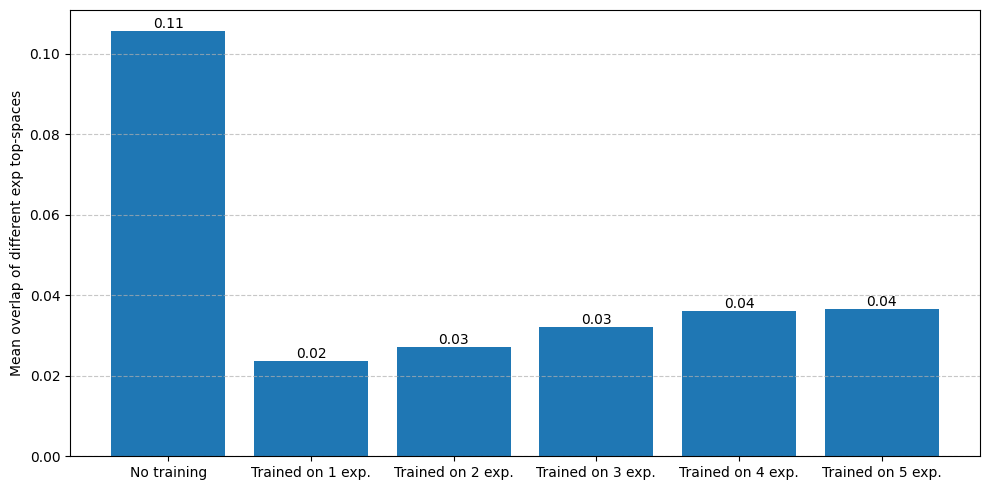

In [418]:
experiments_list = ["ewc", "naive", "bsgp-gs-reg", "bsgp-of", "bsgp-gs", "bsgp-ol", "agem", "gpm", "bsgp-of-reg", "bsgp-ol-reg", "bsgp-av", "bsgp-av-reg", "ogd"]
mean_overlaps_list = []
for exp in experiments_list:
    mean_overlaps = plot_heatmaps_for_all_t(os.path.join(evec_history, exp))
    mean_overlaps_list.append(mean_overlaps)

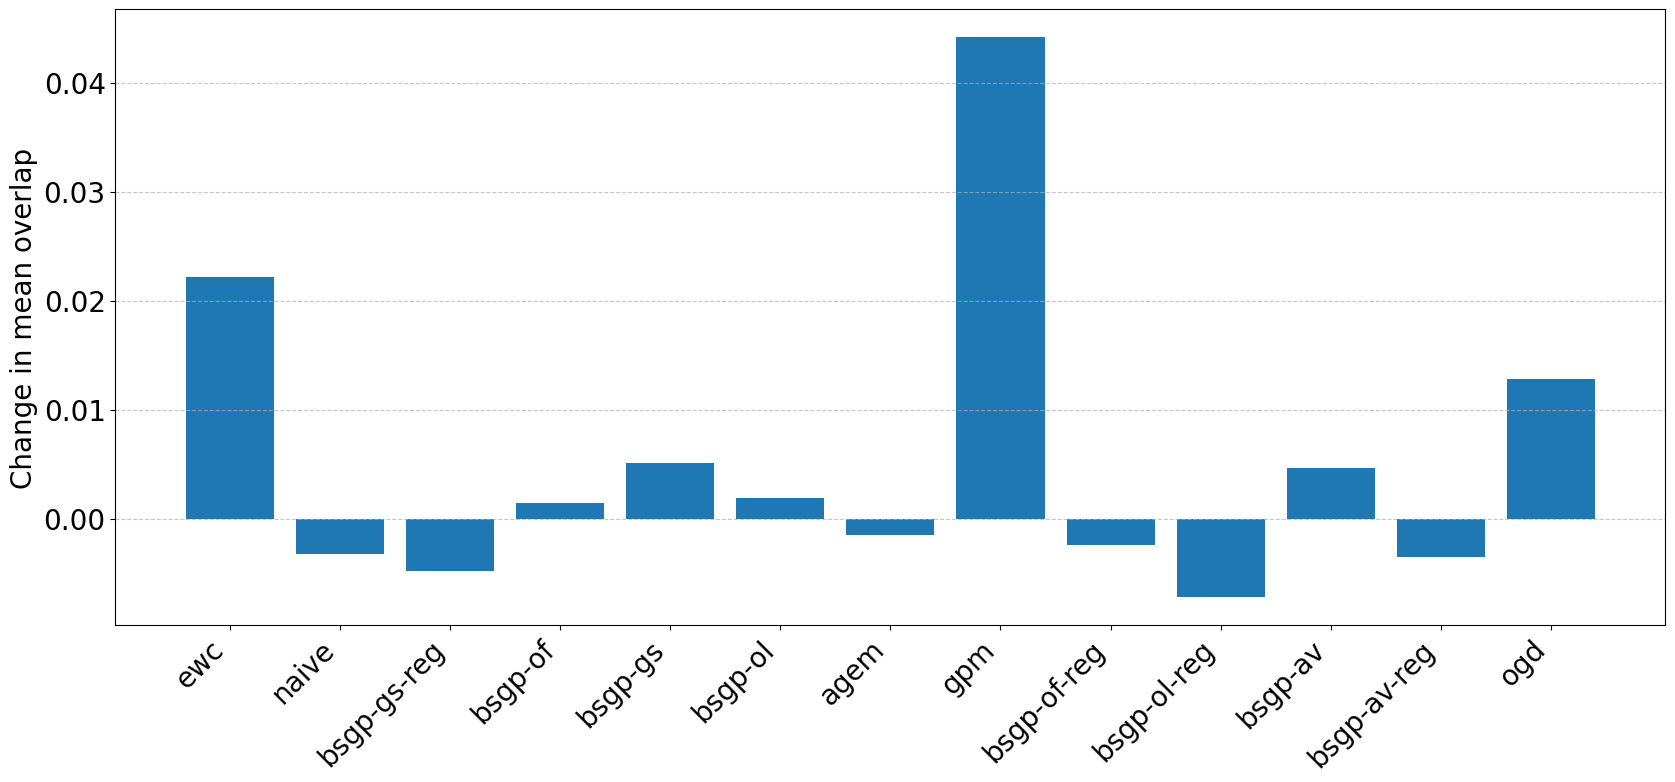

In [419]:
plt.figure(figsize=(20, 8))
plt.bar(experiments_list, [m_overlap[-1] - m_overlap[1] for m_overlap in mean_overlaps_list])
plt.ylabel("Change in mean overlap", fontsize=20)
# plt.title("Change in mean overlap of different exp. top-spaces after training on all exp. relative to the mean overlap after training on the first exp.")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=20)
# Optionally, you can also increase the y-axis label font size for consistency
plt.tick_params(axis='y', labelsize=20)

In [41]:
def plot_overlap(data_dir):
  plt.figure(figsize=(8, 5))
  for i in range(5):
    overlaps = []
    first_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-before-training.pt"), weights_only=True)
    second_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{i}.pt"), weights_only=True)
    overlap = overlap_top_tr(first_top_space, second_top_space)
    overlaps.append(overlap)
    for j in range(5):
      
      first_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{j}.pt"), weights_only=True)
      second_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{i}.pt"), weights_only=True)
      overlap = overlap_top_tr(first_top_space, second_top_space)
      overlaps.append(overlap)
    plt.plot(range(6), overlaps, "o--", label=f"i = {i + 1}.")
  plt.xlabel("Number of trained expiriences (t)", fontsize=20)
  plt.ylabel("Overlap", fontsize=20)
  plt.grid(axis="x")
  plt.legend(fontsize=15)


def plot_overlap_heatmap(data_dir, column_names, row_names):
    # Create a 5x6 matrix to store overlap values
    overlap_matrix = np.zeros((5, 6))

    for i in range(5):
        first_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-before-training.pt"), weights_only=True)
        second_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{i}.pt"), weights_only=True)
        overlap_matrix[i, 0] = overlap_top_tr(first_top_space, second_top_space)
        
        for j in range(5):
            first_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{j}.pt"), weights_only=True)
            second_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{i}.pt"), weights_only=True)
            overlap_matrix[i, j+1] = overlap_top_tr(first_top_space, second_top_space)

    # Create the heatmap
    plt.figure(figsize=(10, 4))
    ax = sns.heatmap(overlap_matrix, annot=True,
                 fmt=".2f", cmap="YlGnBu", 
                 xticklabels=column_names,
                 yticklabels=row_names,
                 annot_kws={"size": 14, "weight": "bold"})
    ax.collections[0].colorbar.ax.set_ylabel("Overlap", fontsize=14, fontweight="bold")
    plt.xlabel("Number of trained experiences (t)", fontsize=14, fontweight="bold")
    plt.ylabel("Anchor dominant subsapce and i value", fontsize=10, fontweight="bold")
    plt.xticks(fontsize=14, fontweight="bold")
    plt.yticks(fontsize=10, fontweight="bold")
    # plt.title("Overlap Heatmap", fontsize=20)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

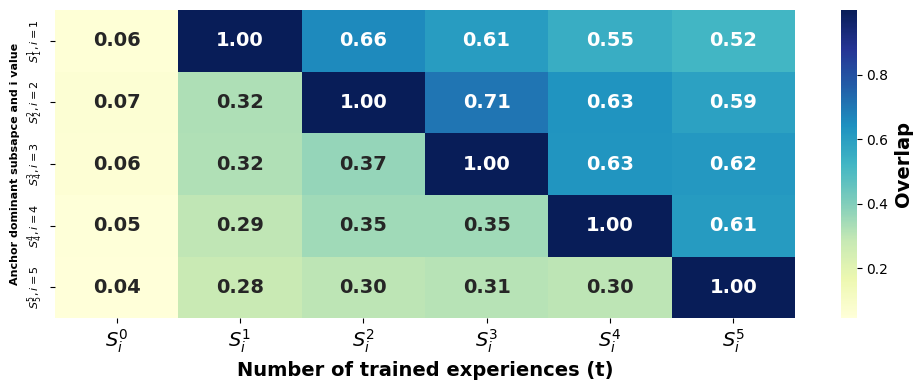

In [42]:
row_names = ["$S^1_1, i = 1$", "$S^2_2, i = 2$", "$S^3_4, i = 3$", "$S^4_4, i = 4$", "$S^5_5, i = 5$"]
column_names = ["$S^0_i$", "$S^1_i$", "$S^2_i$", "$S^3_i$", "$S^4_i$", "$S^5_i$"]
plot_overlap_heatmap(os.path.join(evec_history, "bsgp-gs-reg"), column_names, row_names)

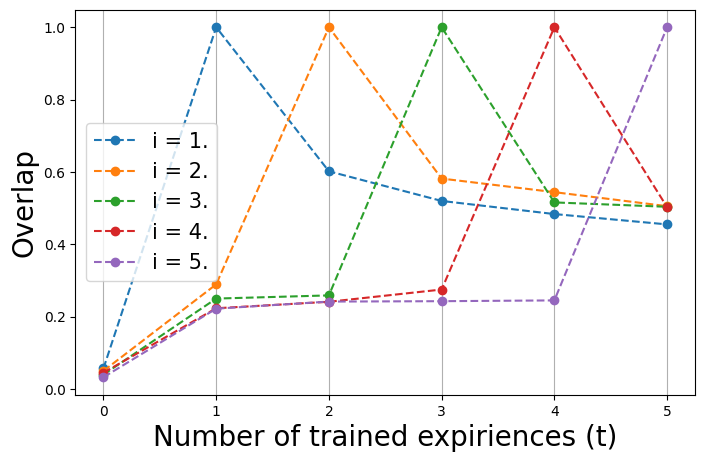

In [393]:
plot_overlap(os.path.join(evec_history, "naive"))

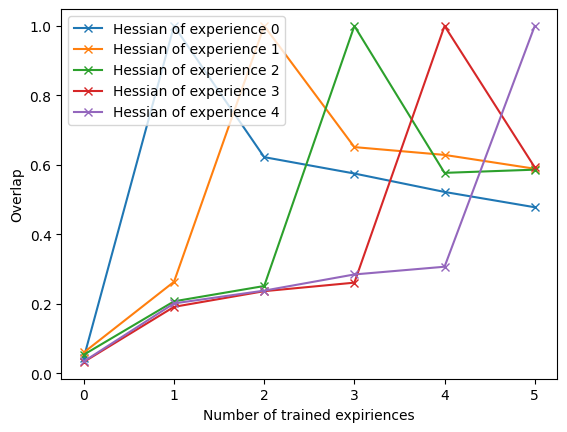

In [106]:
plot_overlap(os.path.join(evec_history, "gpm"))

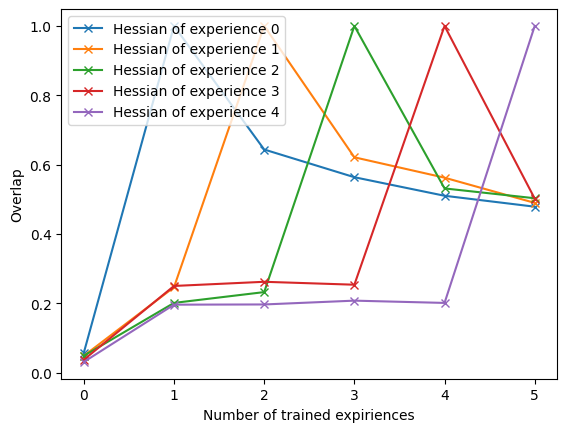

In [107]:
plot_overlap(os.path.join(evec_history, "bsgp-gs"))

In [20]:
def calculate_mean_overlap_with_last(data_dir):
    overlap_sum = 0
    overlap_num = 0
    for i in range(4):
        first_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{4}.pt"), weights_only=True)
        second_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{i}.pt"), weights_only=True)
        overlap = overlap_top_tr(first_top_space, second_top_space)
        overlap_sum += float(overlap)
        overlap_num += 1
    return overlap_sum / overlap_num

def calculate_mean_overlap_with_next(data_dir):
    overlap_sum = 0
    overlap_num = 0
    for i in range(4):
        first_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{i + 1}.pt"), weights_only=True)
        second_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{i}.pt"), weights_only=True)
        overlap = overlap_top_tr(first_top_space, second_top_space)
        overlap_sum += float(overlap)
        overlap_num += 1
    return overlap_sum / overlap_num

def calculate_mean_overlap_first_expirience(data_dir):
    overlap_sum = 0
    overlap_num = 0
    for i in range(1, 5):
        first_top_space = torch.load(os.path.join(data_dir, f"eivs-{0}-after-training-{0}.pt"), weights_only=True)
        second_top_space = torch.load(os.path.join(data_dir, f"eivs-{0}-after-training-{i}.pt"), weights_only=True)
        overlap = overlap_top_tr(first_top_space, second_top_space)
        overlap_sum += float(overlap)
        overlap_num += 1
    return overlap_sum / overlap_num

In [12]:
experiments_list = ["ewc", "naive", "bsgp-gs-reg", "bsgp-of", "bsgp-gs", "bsgp-ol", "agem", "gpm", "bsgp-of-reg", "bsgp-ol-reg", "bsgp-av", "bsgp-av-reg"]
# colors = ["blue", "#a1a1a1", 'red', '#FF662A', '#4F3F84', '#82AC26', "yellow"]
experiments_names = ["ewc", "naive", "BSGP Gram-Schmidt (with regularization)", "BSGP Only First", "BSGP Gram-Sxhmidt (no regularization)", "BSGP Only Last", "A-GEM", "gpm", "bsgp-of-reg", "bsgp-ol-reg", "bsgp-av", "bsgp-av-reg"]

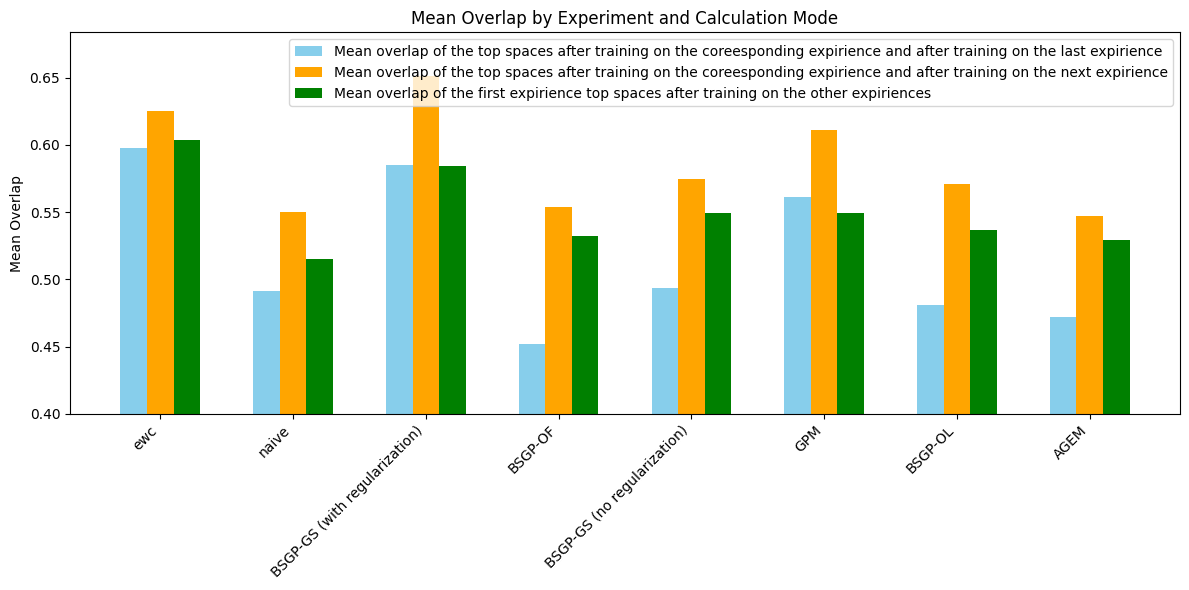

In [117]:
# Create the histogram plot
experiment_mean_overlap_with_last = {}
experiment_mean_overlap_with_next = {}
experimet_mean_overlap_first_expirience = {}
for experiment in experiments_list:
    experiment_mean_overlap_with_last[experiment] = calculate_mean_overlap_with_last(os.path.join(evec_history, experiment))
    experiment_mean_overlap_with_next[experiment] = calculate_mean_overlap_with_next(os.path.join(evec_history, experiment))
    experimet_mean_overlap_first_expirience[experiment] = calculate_mean_overlap_first_expirience(os.path.join(evec_history, experiment))

# Prepare data for plotting
overlap_with_last = list(experiment_mean_overlap_with_last.values())
overlap_with_next = list(experiment_mean_overlap_with_next.values())
overlap_of_first = list(experimet_mean_overlap_first_expirience.values())

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar and the positions of the bars
width = 0.2
x = np.arange(len(experiments_names))

# Create the bars
rects1 = ax.bar(x - width, overlap_with_last, width, label='Mean overlap of the top spaces after training on the coreesponding expirience and after training on the last expirience', color='skyblue')
rects2 = ax.bar(x, overlap_with_next, width, label='Mean overlap of the top spaces after training on the coreesponding expirience and after training on the next expirience', color='orange')
rects3 = ax.bar(x + width, overlap_of_first, width, label='Mean overlap of the first expirience top spaces after training on the other expiriences', color='green')

# Customize the plot
ax.set_ylabel('Mean Overlap')
ax.set_title('Mean Overlap by Experiment and Calculation Mode')
ax.set_xticks(x)
ax.set_xticklabels(experiments_names, rotation=45, ha='right')
ax.legend()

# Set y-axis to start from 0.7
ax.set_ylim(bottom=0.4)

# Add some padding to the bottom of the plot to prevent cutting off x-labels
plt.tight_layout()

# Show the plot
plt.show()


In [22]:
import wandb
api = wandb.Api()

In [394]:
NAIVE = "dknorre-eth-z-rich/ETH-DL-Project/runs/0saayw3g"
BSGP_OF = "dknorre-eth-z-rich/ETH-DL-Project/runs/p82ql9lt"
BSGP_GS = "dknorre-eth-z-rich/ETH-DL-Project/runs/8z4ynbls"
AGEM = "dknorre-eth-z-rich/ETH-DL-Project/runs/x9fmhnxd"
BSGP_GS_REG = "dknorre-eth-z-rich/ETH-DL-Project/runs/ow3k8xax"
BSGP_OL = "dknorre-eth-z-rich/ETH-DL-Project/runs/i7bpnqhh"
EWC = "dknorre-eth-z-rich/ETH-DL-Project/runs/79n20cqh"
BSGP_AV = "dknorre-eth-z-rich/ETH-DL-Project/runs/k62y2gbe"
BSGP_AV_REG = "dknorre-eth-z-rich/ETH-DL-Project/runs/z78k45ee"
BSGP_OL_REG = "dknorre-eth-z-rich/ETH-DL-Project/runs/yctos2oi"
BSGP_OF_REG = "dknorre-eth-z-rich/ETH-DL-Project/runs/cvugftwe"
OGD = "dknorre-eth-z-rich/ETH-DL-Project/runs/wf3muqvu"



In [395]:
experiments_list = ["ewc", "naive", "bsgp-gs-reg", "bsgp-of", "bsgp-gs", "bsgp-ol", "agem", "bsgp-of-reg", "bsgp-ol-reg", "bsgp-av", "bsgp-av-reg", "ogd"]
mask = [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
colors_scatter_plot = [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]

In [396]:
algorithms = [EWC, NAIVE, BSGP_GS_REG,  BSGP_OF, BSGP_GS, BSGP_OL, AGEM, BSGP_AV, BSGP_AV_REG, BSGP_OL_REG, BSGP_OF_REG, OGD]
algorithms_labels = ["ewc", "naive", "bsgp-gs-reg", "bsgp-of", "bsgp-gs", "bsgp-ol", "agem",  "bsgp-av", "bsgp-av-reg", "bsgp-ol-reg", "bsgp-of-reg", "ogd"]
experiments_names = ["ewc", 
                     "naive", 
                     "BSGP Gram-Schmidt", 
                     "BSGP Only First",
                     "BSGP Gram-Schmidt", 
                     "BSGP Only Last", 
                     "A-GEM", 
                     "BSGP Only First", 
                     "BSGP Only Last", 
                     "BSGP Average", 
                     "BSGP Average",
                     "OGD"]
algorithms_dict = {label: algo for label, algo in zip(algorithms_labels, algorithms)}

In [196]:

def get_bwt(api, path):
    run = api.run(path)
    for record in run.scan_history():
        if "BWT" in record.keys() and record["BWT"] is not None:
            return record["BWT"]
    
def get_acc(api, path):
    run = api.run(path)
    for record in run.scan_history():
        if "ACC" in record.keys() and record["ACC"] is not None:
            return record["ACC"]


In [197]:
def calculate_mean_overlap(experiment_path, overlap_type, label):
    # This function should be implemented to calculate the mean overlap
    # based on the overlap_type ('with_last', 'with_next', 'first_experience')
    # and return the calculated value
    if overlap_type == "with_last":
        return calculate_mean_overlap_with_last(experiment_path)
    elif overlap_type == "with_next":
        return calculate_mean_overlap_with_next(experiment_path)
    elif overlap_type == "first_experience":
        return calculate_mean_overlap_first_expirience(experiment_path)
    elif overlap_type == "BWT":
        return get_bwt(api, algorithms_dict[label])
    elif overlap_type == "ACC":
        return get_acc(api, algorithms_dict[label])
    

In [198]:
def get_data(experiments_list, evec_history):
    # Data collection
    overlap_types = ['with_last', 'with_next', 'first_experience', "BWT"]
    
    
    experiment_data = {exp: {} for exp in experiments_list}

    for experiment in experiments_list:
        for overlap_type in overlap_types:
            experiment_data[experiment][overlap_type] = calculate_mean_overlap(
                os.path.join(evec_history, experiment), overlap_type, experiment
            )

    # Prepare data for plotting
    data = [[experiment_data[exp][ot] for exp in experiments_list] for ot in overlap_types]
    return data

In [398]:
data = get_data(experiments_list, evec_history)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: Network error (HTTPError), entering retry loop.
wandb: WARNING A graphql request initiated by the public wand

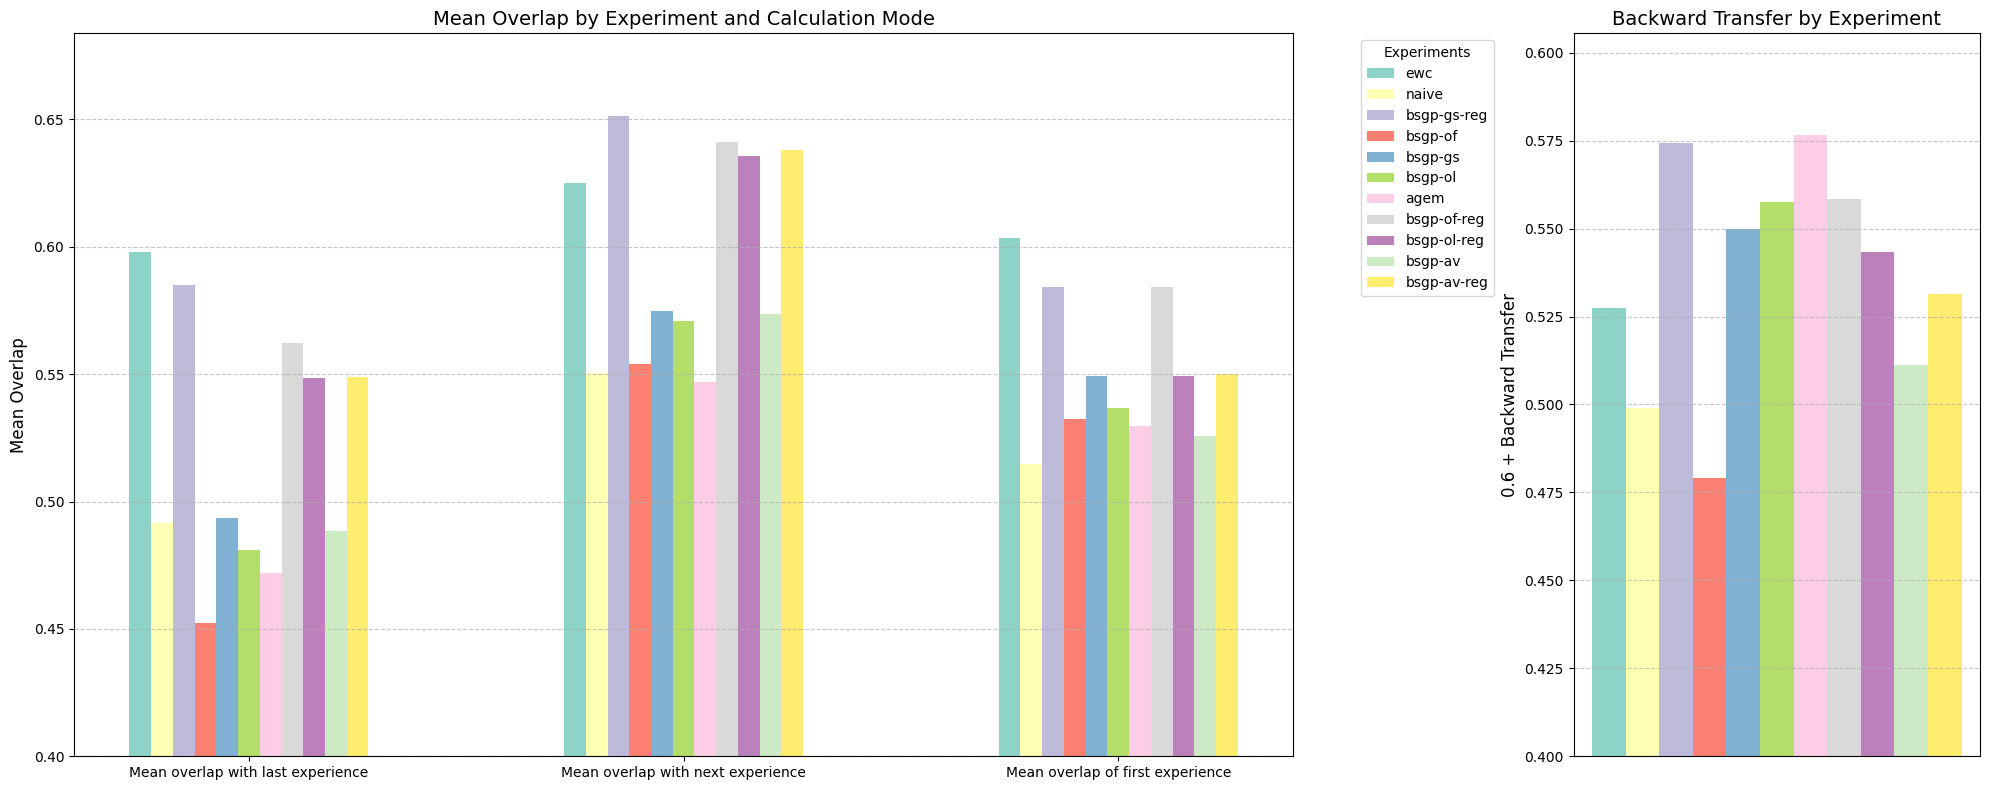

In [227]:
def plot_mean_overlap(experiments_list, experiments_names, data):
    # Data collection
    overlap_types = ['with_last', 'with_next', 'first_experience', "BWT"]
    overlap_labels = {
        'with_last': 'Mean overlap with last experience',
        'with_next': 'Mean overlap with next experience',
        'first_experience': 'Mean overlap of first experience',
        'BWT': 'Backward Transfer'
    }


    # Set up the plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [3, 1]})

    # Set the width of each bar group and the positions of the bars
    width = 0.05
    x = np.arange(len(overlap_types) - 1)  # Exclude BWT from main plot

    # Create the grouped bars for overlap types
    colors = colormaps['Set3'](np.linspace(0, 1, len(experiments_list)))
    for i, (_, color) in enumerate(zip(experiments_list, colors)):
        ax1.bar(x + i*width, [d[i] for d in data[:-1]], width, label=experiments_names[i], color=color)

    # Customize the main plot (ax1)
    ax1.set_ylabel('Mean Overlap', fontsize=12)
    ax1.set_title('Mean Overlap by Experiment and Calculation Mode', fontsize=14)
    ax1.set_xticks(x + width * (len(experiments_list) - 1) / 2)
    ax1.set_xticklabels([overlap_labels[ot] for ot in overlap_types[:-1]])
    ax1.legend(title='Experiments', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax1.set_ylim(bottom=0.4)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Create the grouped bars for BWT (ax2)
    for i, (_, color) in enumerate(zip(experiments_list, colors)):
        ax2.bar(i*width, 0.6 + data[-1][i], width, label=experiments_names[i], color=color)

    # Customize the BWT plot (ax2)
    ax2.set_ylabel('0.6 + Backward Transfer', fontsize=12)
    ax2.set_title('Backward Transfer by Experiment', fontsize=14)
    ax2.set_xticks([])  # Remove x-ticks
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.set_ylim(bottom=0.4)


    # Add some padding to the plot
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_mean_overlap(experiments_list, experiments_list, data)

In [387]:
def make_scatter_plot(bwts, overlaps, labels, regularization, offsets):
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    
    # Create a list of unique regularization values
    unique_reg = list(set(regularization))
    
    # Create a color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_reg)))
    
    # Plot each point
    for i, (bwt, overlap, label, reg) in enumerate(zip(bwts, overlaps, labels, regularization)):
        color = colors[unique_reg.index(reg)]
        if reg == 0:
            plt.scatter(bwt, overlap, s=100, c=[color], label=f'No regularisation')
        else:
            plt.scatter(bwt, overlap, s=100, c=[color], label=f'With regularisation')
        # Add labels to each point
        plt.annotate(label, (bwt, overlap), xytext=offsets[i], 
                     textcoords='offset points', fontsize=16, fontweight='bold')
    
    # Set labels and title
    plt.xlabel('Backward Transfer', fontsize=22)
    plt.ylabel('Mean Overlap', fontsize=22)
    
    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend and remove duplicate labels
    handles, legend_labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(legend_labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=20)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [388]:
experiments_names

['ewc',
 'naive',
 'BSGP Gram-Schmidt',
 'BSGP Only First',
 'BSGP Gram-Schmidt',
 'BSGP Only Last',
 'A-GEM',
 'BSGP Only First',
 'BSGP Only Last',
 'BSGP Average',
 'BSGP Average']

In [407]:
offsets = [(5, -20), (5, 8), (-180, -20), (5, 8), (-40, 8), (-40, -20), (-40, -20), (-50, 8), (5, -20), (5, 8), (5, 8), (-50, 8)]

In [408]:
table_data = [-0.07, -0.16, -0.03, -0.1, -0.05, -0.09, -0.03, -0.04, -0.0495, -0.09, -0.0505, -0.09]

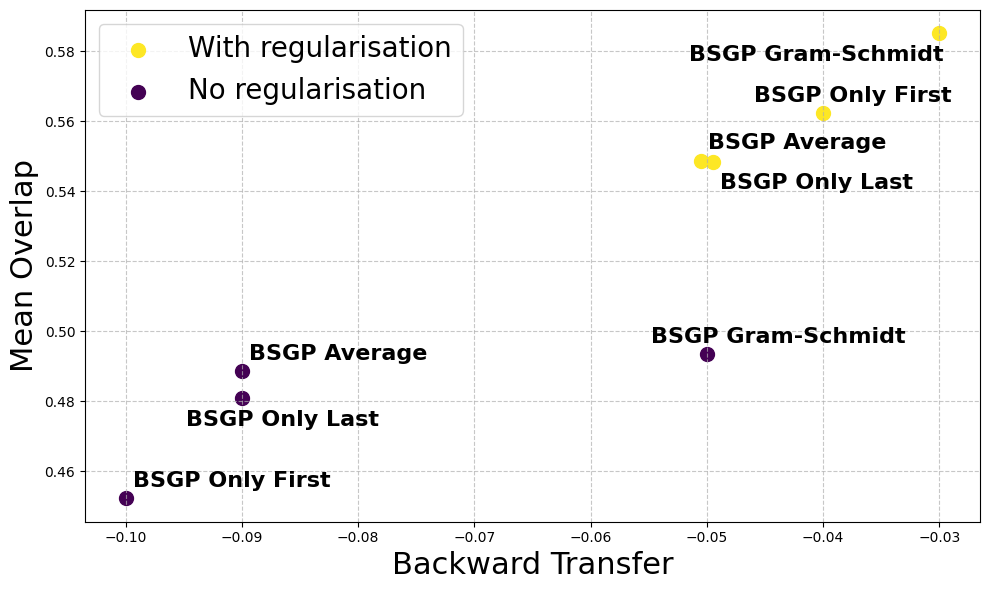

In [409]:

make_scatter_plot(np.array(table_data)[np.array(mask) == 1], 
                  np.array(data[0])[np.array(mask) == 1], 
                  np.array(experiments_names)[np.array(mask) == 1],
                  np.array(colors_scatter_plot)[np.array(mask) == 1],
                  np.array(offsets)[np.array(mask) == 1])

In [411]:
data[0]

[0.5978545993566513,
 0.49151749163866043,
 0.585121750831604,
 0.4521968737244606,
 0.4935140609741211,
 0.4809313341975212,
 0.4718038961291313,
 0.5623510181903839,
 0.5484416037797928,
 0.48854319751262665,
 0.5487552508711815,
 0.4911489635705948]

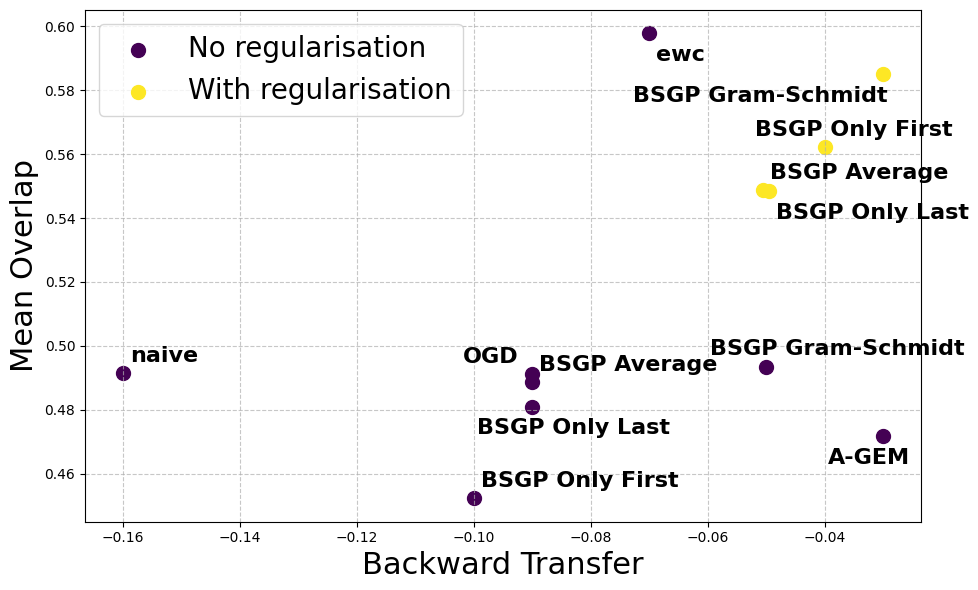

In [410]:
make_scatter_plot(np.array(table_data), 
                  np.array(data[0]), 
                  np.array(experiments_names),
                  np.array(colors_scatter_plot),
                  np.array(offsets))

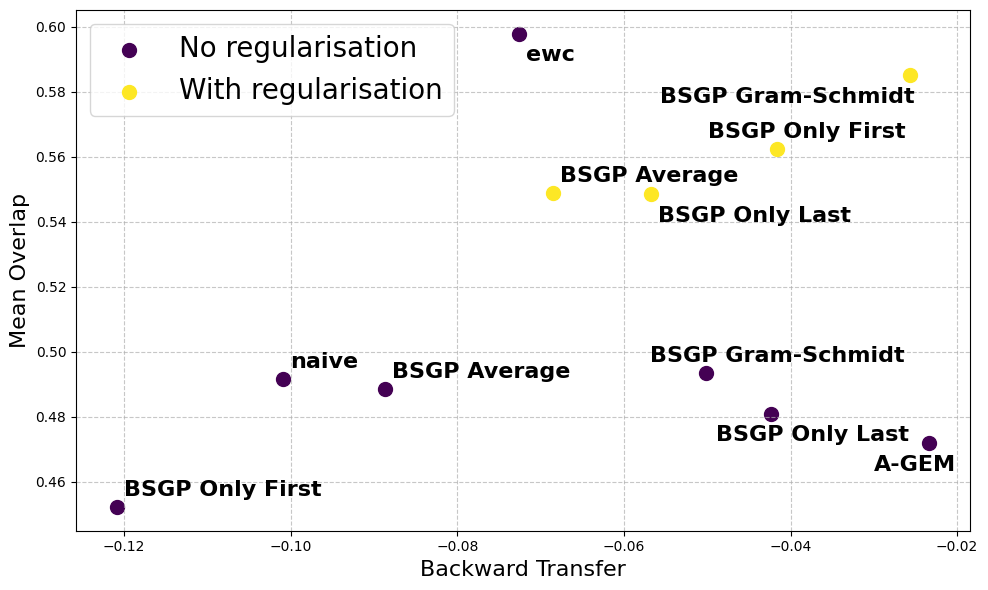

In [376]:
make_scatter_plot(np.array(data[-1]), 
                  np.array(data[0]), 
                  np.array(experiments_names),
                  np.array(colors_scatter_plot),
                  np.array(offsets))

In [6]:
def plot_overlap_subsequent(data_dir):
  for i in range(5):
    overlaps = []
    # first_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-before-training.pt"), weights_only=True)
    # second_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{i}.pt"), weights_only=True)
    # overlap = overlap_top_tr(first_top_space, second_top_space)
    # overlaps.append(overlap)
    for j in range(i + 1, 5):
      
      first_top_space = torch.load(os.path.join(data_dir, f"eivs-{j}-after-training-{j}.pt"), weights_only=True)
      second_top_space = torch.load(os.path.join(data_dir, f"eivs-{i}-after-training-{i}.pt"), weights_only=True)
      overlap = overlap_top_tr(first_top_space, second_top_space)
      overlaps.append(overlap)
    plt.plot(range(i + 1, 5), overlaps, "x-", label=f"Hessian of experience {i}")
  plt.xlabel("Number of trained expiriences")
  plt.ylabel("Overlap")
  plt.legend()

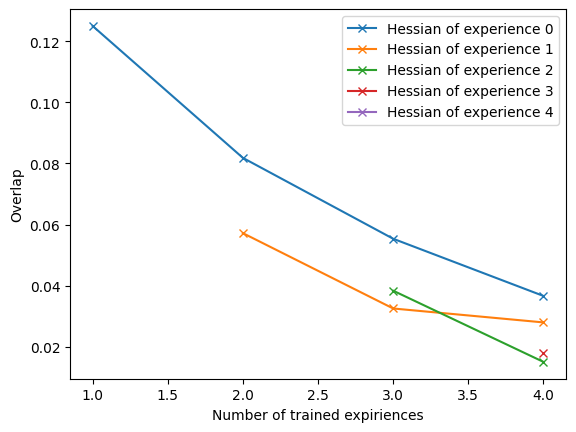

In [7]:
plot_overlap_subsequent(os.path.join(evec_history, "naive"))

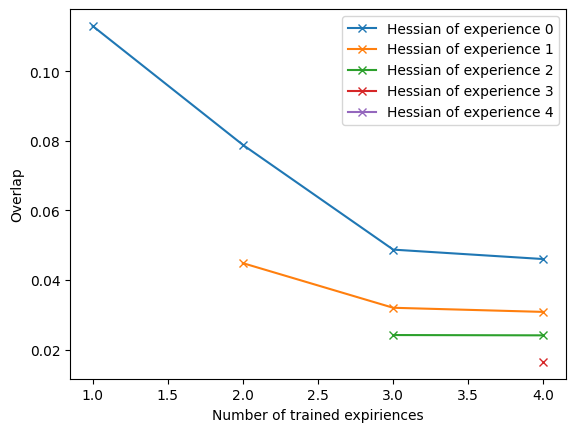

In [8]:
plot_overlap_subsequent(os.path.join(evec_history, "bsgp-gs-reg"))

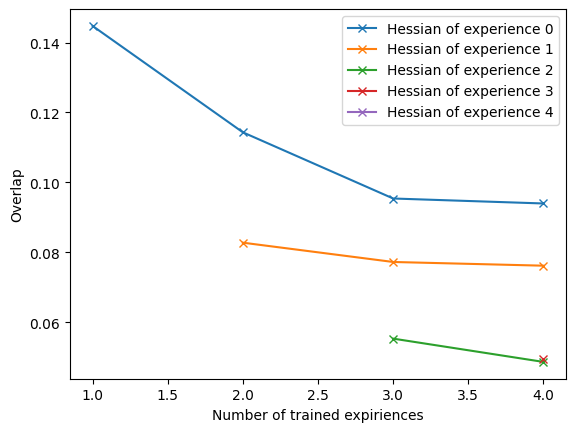

In [9]:
plot_overlap_subsequent(os.path.join(evec_history, "ewc"))

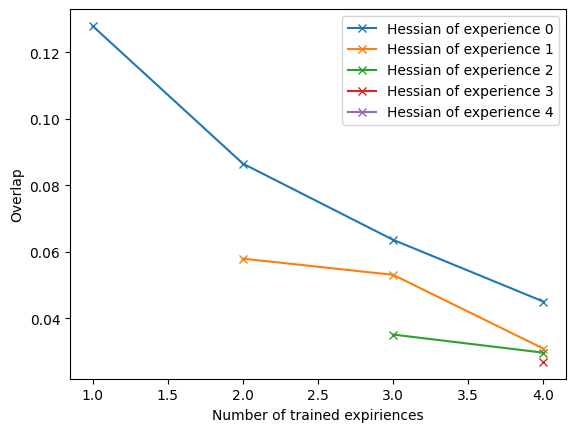

In [10]:
plot_overlap_subsequent(os.path.join(evec_history, "bsgp-gs"))

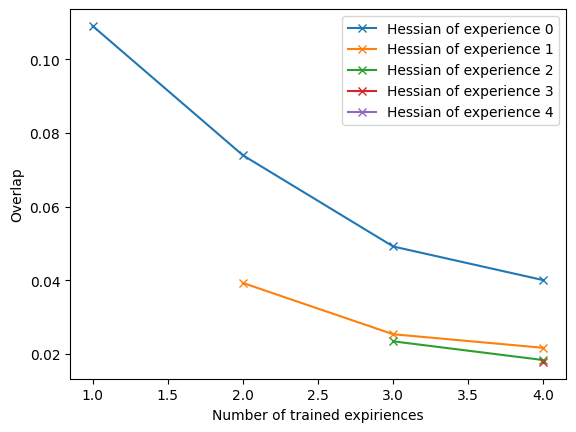

In [11]:
plot_overlap_subsequent(os.path.join(evec_history, "agem"))